# Run Ref umt

In [1]:
# Env: sc2_v0
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import calendar
import os

In [36]:
site = 'umt'
site_longname = 'Umiujaq TUNDRA, northeastern Canada'
y_start = 2012
y_end = 2021

# les ref ici étaient 100% Shrub EG -> changé en 50% Shru decidious avec peat (suite aux tests)
labels = ['Ref', 'Ref_peat', '50sh_nopeat', '50sh_peat', 'bg_nopeat', 'bg_nopeat']

root_path = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowArctic/'+site+'/'
paths = [root_path+'run_'+label for label in labels]

ds_yr_list = [xr.open_mfdataset(path+'/*_annually.nc').squeeze().load() for path in paths]
ds_mo_list = [xr.open_mfdataset(path+'/*_monthly.nc').squeeze().load() for path in paths]
ds_d_list = [xr.open_mfdataset(path+'/*_daily.nc').squeeze().load() for path in paths]
# ds_hh_list = [xr.open_mfdataset(path+'/*_halfhourly.nc').squeeze().load() for path in paths]

In [37]:
path = "/home/lalandmi/eccc/classic-develop/inputFiles/SnowArctic/"+site
rsfile = xr.open_dataset(path+'/rsfile_spinup-final_'+labels[0]+'.nc')

In [38]:
def assign_center_depth(ds, rsfile):
    layer_c = []
    for i in range(len(rsfile.DELZ)):
        if i == 0:
            layer_c.append(rsfile.DELZ.cumsum().values[i]/2)
        else:
            layer_c.append(rsfile.DELZ.cumsum().values[i-1] + rsfile.DELZ.values[i]/2)
    with xr.set_options(keep_attrs=True):
        ds = ds.assign_coords(layer=ds.layer*0+layer_c)
    return ds

In [39]:
for i in range(len(labels)):
    ds_yr_list[i] = assign_center_depth(ds_yr_list[i], rsfile)
    ds_mo_list[i] = assign_center_depth(ds_mo_list[i], rsfile)
    ds_d_list[i] = assign_center_depth(ds_d_list[i], rsfile)
    # ds_hh_list[i] = assign_center_depth(ds_hh_list[i], rsfile)

Text(0.5, 0.98, 'Umiujaq TUNDRA, northeastern Canada')

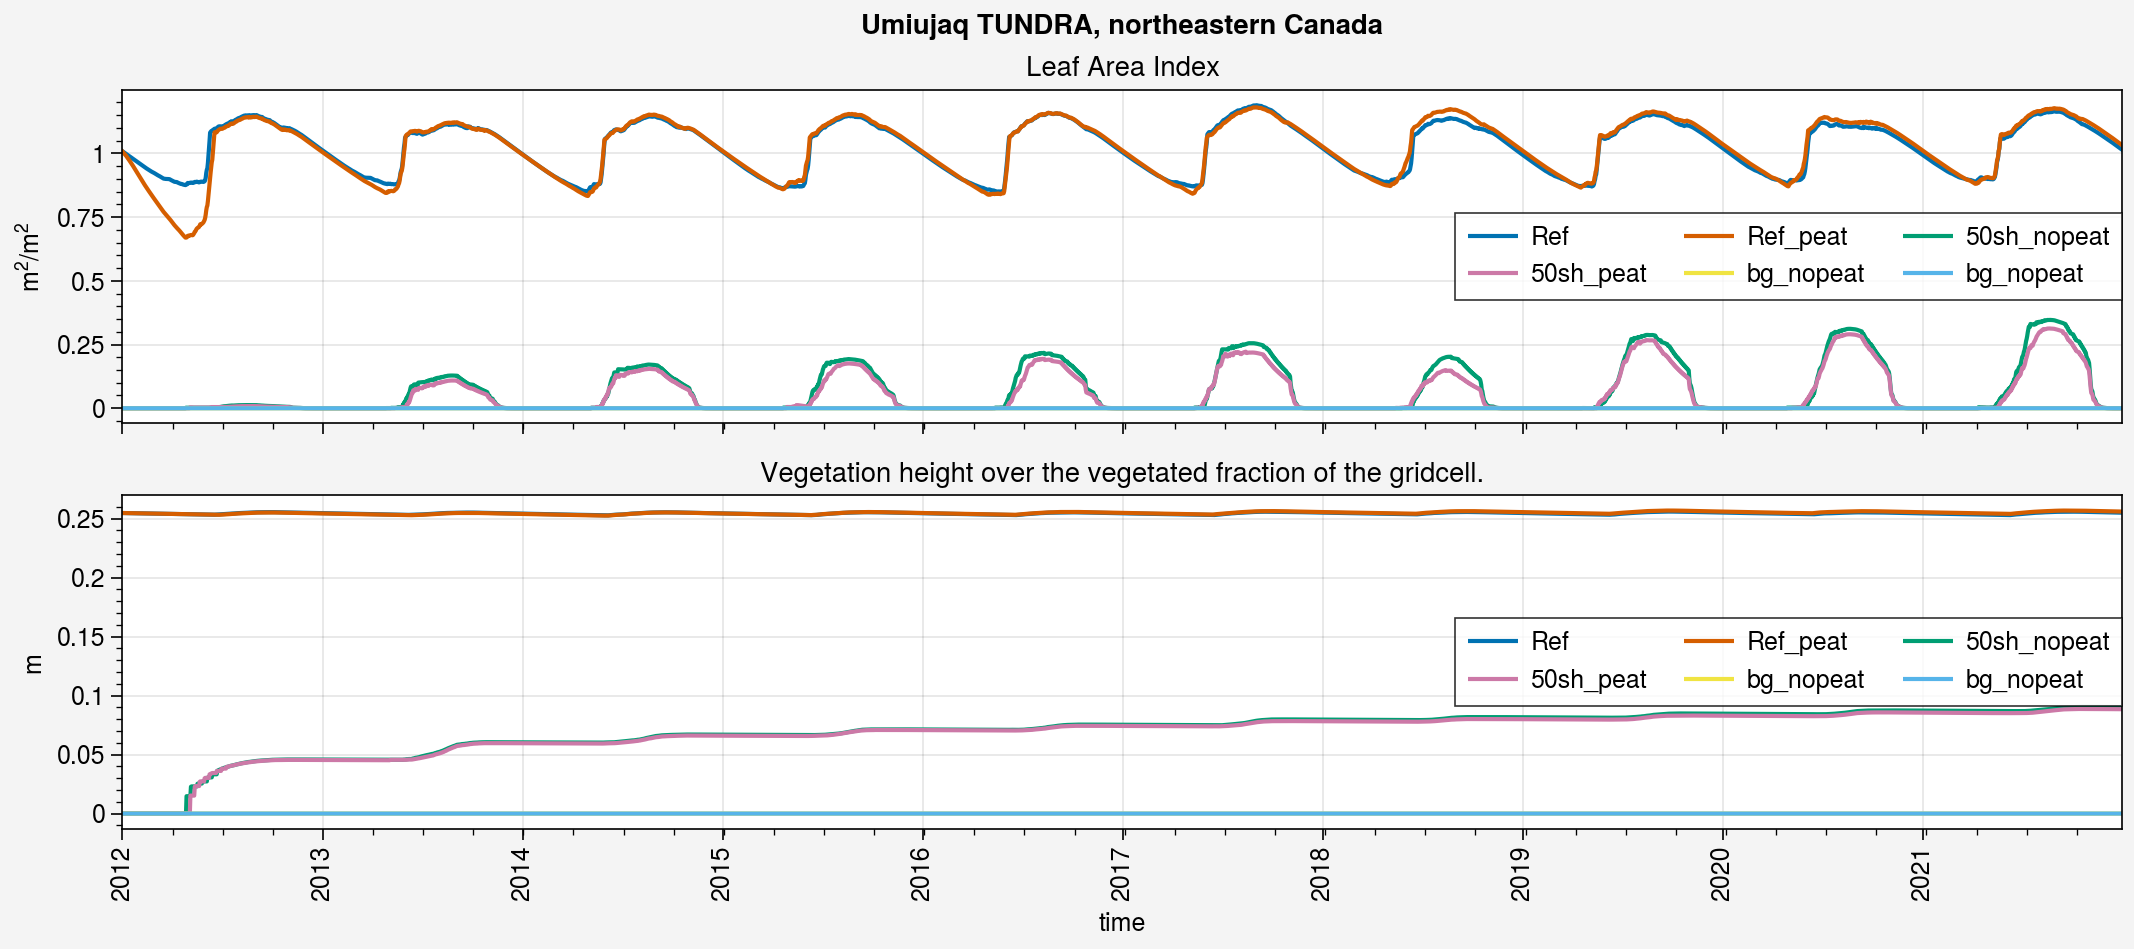

In [41]:
%matplotlib inline
fig, axs = pplt.subplots(ncols=1, nrows=2, refaspect=6, refwidth=10, sharey=0)

for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.lai, label=label)
    axs[1].plot(ds_d.vegHeight, label=label)

axs[0].format(ylabel=ds_d_list[0].lai.units, title=ds_d_list[0].lai.long_name)
axs[1].format(ylabel=ds_d_list[0].vegHeight.units, title=ds_d_list[0].vegHeight.long_name)

for ax in axs:
    ax.legend()

fig.suptitle(site_longname)

Text(0.5, 0.98, 'Umiujaq TUNDRA, northeastern Canada (2012-2021)')

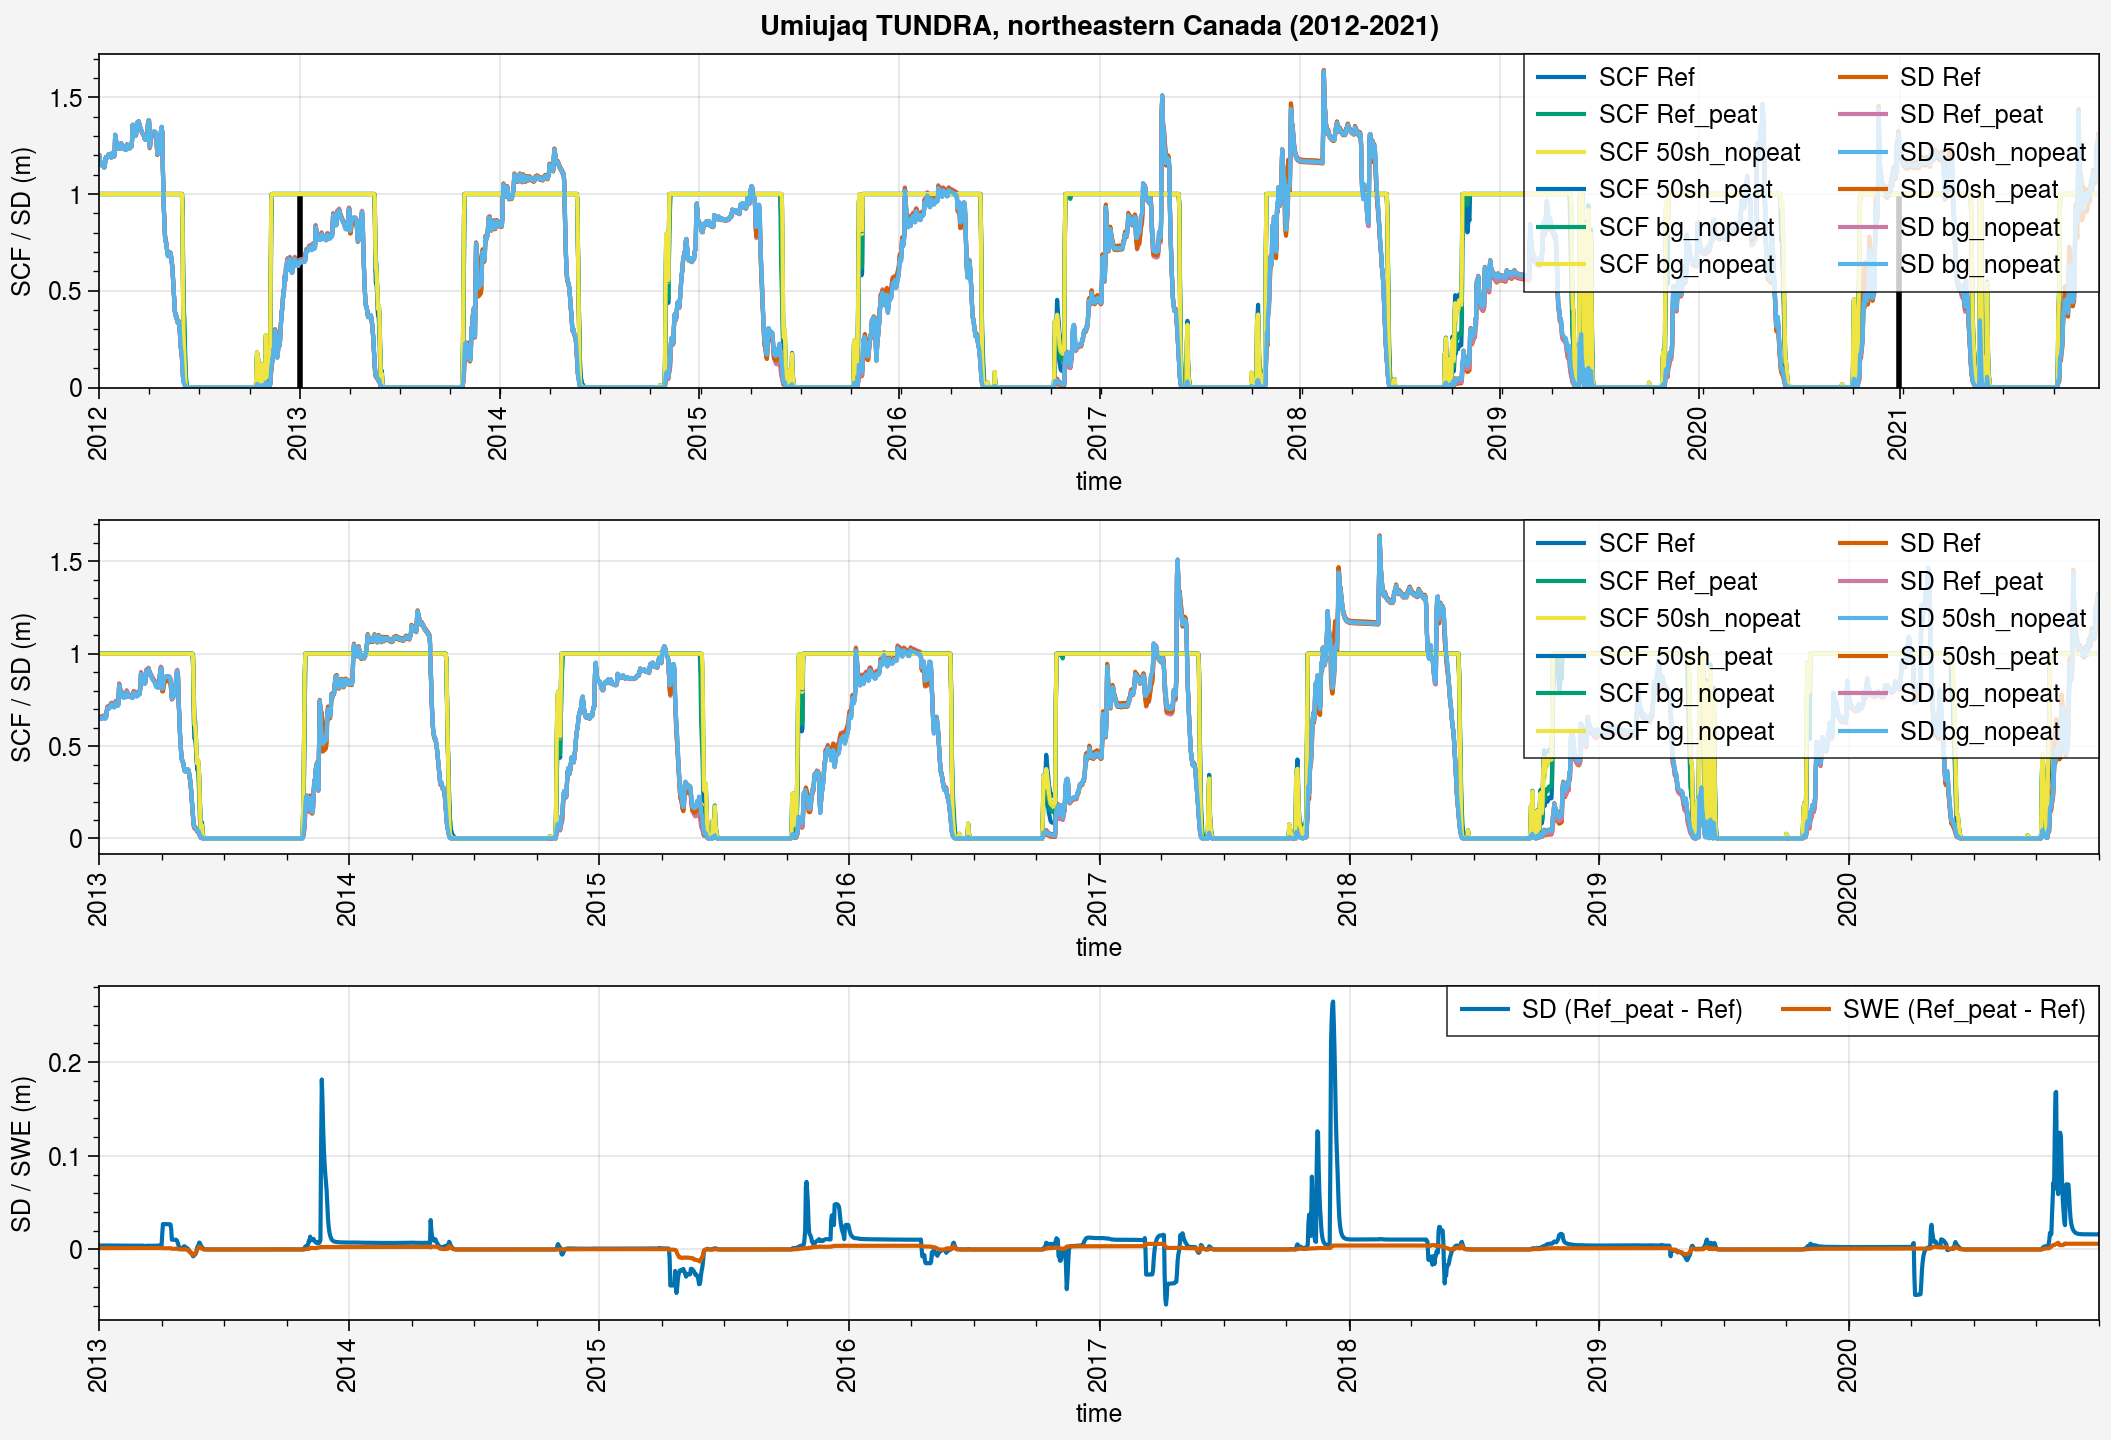

In [42]:
if len(labels) > 1:
    nrows = 3
else: 
    nrows = 2
    
fig, axs = pplt.subplots(ncols=1, nrows=nrows, refaspect=6, refwidth=10, share=0)

##################
### All period ###
##################
start = str(y_start)
end = str(y_end)

for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.snc.sel(time=slice(start,end)), label='SCF '+label)
    axs[0].plot(ds_d.snd.sel(time=slice(start,end)), label='SD '+label)

axs[0].legend(ncols=2, loc='ur')
axs[0].format(
    ylabel='SCF / SD (m)'
)


############
### Zoom ###
############
start = str(y_start+1)
end = str(y_end-1)

for ds_d, label in zip(ds_d_list, labels):
    axs[1].plot(ds_d.snc.sel(time=slice(start,end)), label='SCF '+label)
    axs[1].plot(ds_d.snd.sel(time=slice(start,end)), label='SD '+label)

axs[0].vlines(ds_d_list[0].sel(time=slice(start,end)).time[0], ds_d_list[0].snc.min(), ds_d_list[0].snc.max(), color='k', lw=2)
axs[0].vlines(ds_d_list[0].sel(time=slice(start,end)).time[-1], ds_d_list[0].snc.min(), ds_d_list[0].snc.max(), color='k', lw=2)

axs[1].legend(ncols=2, loc='ur')
axs[1].format(
    ylabel='SCF / SD (m)'
)

if nrows == 3:
    #####################
    ### SWE / SD diff ###
    #####################
    axs[2].plot((ds_d_list[1]-ds_d_list[0]).snd.sel(time=slice(start,end)), label='SD ('+labels[1]+' - '+labels[0]+')')
    axs[2].plot(((ds_d_list[1]-ds_d_list[0]).snw*1e-3).sel(time=slice(start,end)), label='SWE ('+labels[1]+' - '+labels[0]+')')
    
    axs[2].legend(ncols=2)
    axs[2].format(
        ylabel='SD / SWE (m)'
    )

fig.suptitle(site_longname+' ('+str(y_start)+'-'+str(y_end)+')')


In [30]:
# for period in [
#     slice(str(y_start)+'-08-01', str(y_start+1)+'-07-30'),
# ]:

#     collabels = labels
#     for i, (ds, ds_d) in enumerate(zip(ds_hh_list, ds_d_list)):
        
#         fig, axs = pplt.subplots(ncols=1, nrows=5, refaspect=6, refwidth=6, sharey=0)
    
#         #############################
#         ### Fractions of subareas ###
#         #############################

#         variables = {
#             'fcs': {'color': 'blue4', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
#             'fc': {'color': 'green', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
#             'fgs': {'color': 'blue8', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
#             'fg': {'color': 'brown', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
#         }

#         ax = axs[0]
#         for key in variables.keys():
#             ax.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
#                     color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
#         ax.legend(ncols=1, loc='ul')
#         ax.format(ylabel='Fraction of subareas', title='Subareas', ylim=(-0.05,1.05))

#         ##############################
#         ### Snow related variables ###
#         ##############################

#         variables = {
#             'snd': {'color': 'pastel blue', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
#             'snw': {'color': 'blue6', 'ls': '-', 'lw': 1.5, 'factor': 1e-3*10, 'shift': 0},
#             'wsnw': {'color': 'blue6', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 0},
#             'scanopy': {'color': 'k', 'ls': '--', 'lw': 1, 'factor': 1e-3*10, 'shift': 0},
#             'pr': {'color': 'blue3', 'ls': '-', 'lw': 1, 'factor': 500, 'shift': 0},
#         #     'albs': {'color': 'blue6', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 0},
#     #         'mrron': {'color': 'blue6', 'ls': '--', 'lw': 1, 'factor': 10, 'shift': 0},
#         #     'snm': {'color': 'blue8', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 0},
#         }

#         ax = axs[1]
#         for key in variables.keys():
#             ax.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
#                     color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
#         ax.plot(ds_d.vegHeight.sel(time=period), label=ds_d.vegHeight.name, color='green', ls='-', lw=1)
#         # ax.plot(ds_d.lai.sel(time=period), label='LAI', color='green', ls='-', lw=1)
#         ax.legend(ncols=1, loc='ul')
#         ax.format(ylabel='m / mm (wsnw, pr) /\ndam (snw/scanopy)', title='Snow')

#         variables = {
#             'snc': {'color': 'silver', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
#         }
#         ox = ax.alty(label='Snow Cover Fraction')
#         for key in variables.keys():
#             ox.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
#                     color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
#         ox.plot(ds_d.albs.sel(time=period), label='albs', color='yellow7', ls='-', lw=0.8)
#         ox.plot(ds_d.albsn.sel(time=period), label='albsn', color='yellow7', ls='--', lw=0.8, alpha=0.5)
#         ox.legend(ncols=1, loc='ur')
#         ox.format(ylim=(-0.05,1.05))


#         ##############################
#         ### Surface energy budget ###
#         ##############################

#         variables = {
#             'rss': {'color': 'yellow5', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
#             'rls': {'color': 'orange7', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
#         #     'rlds': {'color': 'orange7', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 0},
#             'hfss': {'color': 'teal7', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
#             'hfls': {'color': 'cyan6', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
#             'snm': {'color': 'blue6', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 0},
#             'uvas': {'color': 'gray', 'ls': '--', 'lw': 1, 'factor': 10, 'shift': 0},
#         }

#         ax = axs[2]
#         for key in variables.keys():
#             ax.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
#                     color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
#         ax.hlines(0, ds.sel(time=period).time[0], ds.sel(time=period).time[-1], color='k', lw=1, alpha=0.5)
#         ax.legend(ncols=1, loc='ul')
#         ax.format(ylabel='W m$^{-2}$ /\nuvas (10*m/s)', title='Surface energy budget (+ Energy associated with phase change of water in snow pack)')


#         ###################
#         ### Temperature ###
#         ###################

#         variables = {
#             'tas': {'color': 'k', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 273.15},
#             'ts': {'color': 'k', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 273.15},    
#             'tsn': {'color': 'pastel blue', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
#             'tcs': {'color': 'green', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
#         }

#         ax = axs[3]
#         for key in variables.keys():
#             ax.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
#                     color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
#         ax.plot((ds.tsl-273.15).sel(time=period).isel(layer=0), label=ds.tsl.name+' (0-10cm)', color='dirt')
#         ax.plot((ds.tsl-273.15).sel(time=period).isel(layer=1), label=ds.tsl.name+' (10-20cm)', color='gold')
#         # ax.plot(ds_h_eval_menard2019.ts.sel(time=period), color='red', label='ts obs')
#         ax.hlines(0, ds.sel(time=period).time[0], ds.sel(time=period).time[-1], color='k', lw=1, alpha=0.5)
#         ax.legend(ncols=1, loc='ul')
#         ax.format(ylabel='°C', title='Temperature')

        


#         ############################
#         ### Subareas Temperature ###
#         ############################

#         variables = {
#             'ts': {'color': 'k', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 273.15},

#             'tsg': {'color': 'brown', 'ls': '--', 'lw': 1.5, 'factor': 1, 'shift': 273.15},
#             'tsgs': {'color': 'blue8', 'ls': '--', 'lw': 1.5, 'factor': 1, 'shift': 273.15},
#             'tsc': {'color': 'green', 'ls': '--', 'lw': 1.5, 'factor': 1, 'shift': 273.15},
#             'tscs': {'color': 'blue4', 'ls': '--', 'lw': 1.5, 'factor': 1, 'shift': 273.15},
#         }

#         ax = axs[4]
#         for key in variables.keys():
#             ax.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
#                     color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
#         ax.hlines(0, ds.sel(time=period).time[0], ds.sel(time=period).time[-1], color='k', lw=1, alpha=0.5)
#         ax.legend(ncols=1, loc='ul')
#         ax.format(ylabel='°C', title='Subareas Temperature')

#         fig.suptitle(site_longname+' - '+collabels[i])
#         fig.format(abc='(a)', abcloc='r')
#         # fig.save('img/'+labels[i]+'_hh.jpg')

## Compare with obs

In [11]:
path_obs = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Umiujaq/Domine-etal_2024/datasets'
df = pd.read_csv(path_obs+'/Umiujaq_snow_height.tab', skiprows=26, delimiter='\t', parse_dates=['Date/Time'], index_col=['Date/Time'])
df

Event  Snow h [m]
Date/Time                                                
2012-09-28 21:00:00  Umiujaq_2012-2021_Tundra       0.000
2012-09-28 22:00:00  Umiujaq_2012-2021_Tundra       0.000
2012-09-28 23:00:00  Umiujaq_2012-2021_Tundra       0.000
2012-09-29 00:00:00  Umiujaq_2012-2021_Tundra       0.000
2012-09-29 01:00:00  Umiujaq_2012-2021_Tundra       0.000
...                                       ...         ...
2021-10-19 09:00:00  Umiujaq_2015-2021_Forest       0.053
2021-10-19 10:00:00  Umiujaq_2015-2021_Forest       0.034
2021-10-19 11:00:00  Umiujaq_2015-2021_Forest       0.439
2021-10-19 12:00:00  Umiujaq_2015-2021_Forest       0.045
2021-10-19 13:00:00  Umiujaq_2015-2021_Forest       0.043

[130992 rows x 2 columns]

In [12]:
df['Event'][:79338]

Date/Time
2012-09-28 21:00:00    Umiujaq_2012-2021_Tundra
2012-09-28 22:00:00    Umiujaq_2012-2021_Tundra
2012-09-28 23:00:00    Umiujaq_2012-2021_Tundra
2012-09-29 00:00:00    Umiujaq_2012-2021_Tundra
2012-09-29 01:00:00    Umiujaq_2012-2021_Tundra
                                 ...           
2021-10-19 10:00:00    Umiujaq_2012-2021_Tundra
2015-11-26 04:00:00    Umiujaq_2012-2021_Tundra
2015-11-26 05:00:00    Umiujaq_2012-2021_Tundra
2015-11-26 06:00:00    Umiujaq_2012-2021_Tundra
2015-11-26 07:00:00    Umiujaq_2012-2021_Tundra
Name: Event, Length: 79338, dtype: object

In [13]:
path_obs = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Umiujaq/Domine-etal_2024/datasets'

ds_h_obs = xr.open_dataset(path_obs+'/obs_insitu_'+site+'_'+str(y_start)+'_'+str(y_end)+'.nc').load()
ds_h_met = xr.open_dataset(path_obs+'/met_insitu_'+site+'_'+str(y_start)+'_'+str(y_end)+'.nc').load()

ds_d_obs = ds_h_obs.resample(time='D').mean().load()
ds_h_obs

<xarray.Dataset>
Dimensions:   (time: 79386, veg: 2, sdepth: 4)
Coordinates:
  * time      (time) datetime64[ns] 2012-09-28T17:00:00 ... 2021-10-19T10:00:00
  * veg       (veg) object 'lichen' 'lowshrub'
  * sdepth    (sdepth) float64 0.15 0.25 0.35 0.45
Data variables:
    snd_auto  (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0568 nan nan nan nan
    mrsll     (veg, sdepth, time) float64 nan nan nan nan ... nan nan nan nan
    tsl       (veg, sdepth, time) float64 nan nan nan nan ... nan nan nan nan
    albs      (time) float64 0.08978 nan nan nan nan ... 0.0 0.2071 0.2169 0.247
Attributes:
    event:          Umiujaq_2012-2021_Tundra
    link:           https://doi.pangaea.de/10.1594/PANGAEA.964743
    downloaded:     27/02/2024 by Mickaël Lalande
    original_file:  Domine-etal_2024/datasets/Umiujaq_snow_height.tab, Umiuja...

In [15]:
tot_year = y_end - y_start + 1
gap = 4
years = pplt.arange(y_start, y_end)
years

array([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

### SD

In [17]:
ds_d_obs

<xarray.Dataset>
Dimensions:   (veg: 2, sdepth: 4, time: 3309)
Coordinates:
  * veg       (veg) object 'lichen' 'lowshrub'
  * sdepth    (sdepth) float64 0.15 0.25 0.35 0.45
  * time      (time) datetime64[ns] 2012-09-28 2012-09-29 ... 2021-10-19
Data variables:
    snd_auto  (time) float64 0.0 0.01196 0.02252 ... 0.03703 0.05901 0.0582
    mrsll     (time, veg, sdepth) float64 nan nan nan nan ... nan nan nan nan
    tsl       (time, veg, sdepth) float64 nan nan nan nan ... nan nan nan nan
    albs      (time) float64 0.08978 0.0732 0.1486 ... 0.1283 0.119 0.1677
Attributes:
    event:          Umiujaq_2012-2021_Tundra
    link:           https://doi.pangaea.de/10.1594/PANGAEA.964743
    downloaded:     27/02/2024 by Mickaël Lalande
    original_file:  Domine-etal_2024/datasets/Umiujaq_snow_height.tab, Umiuja...

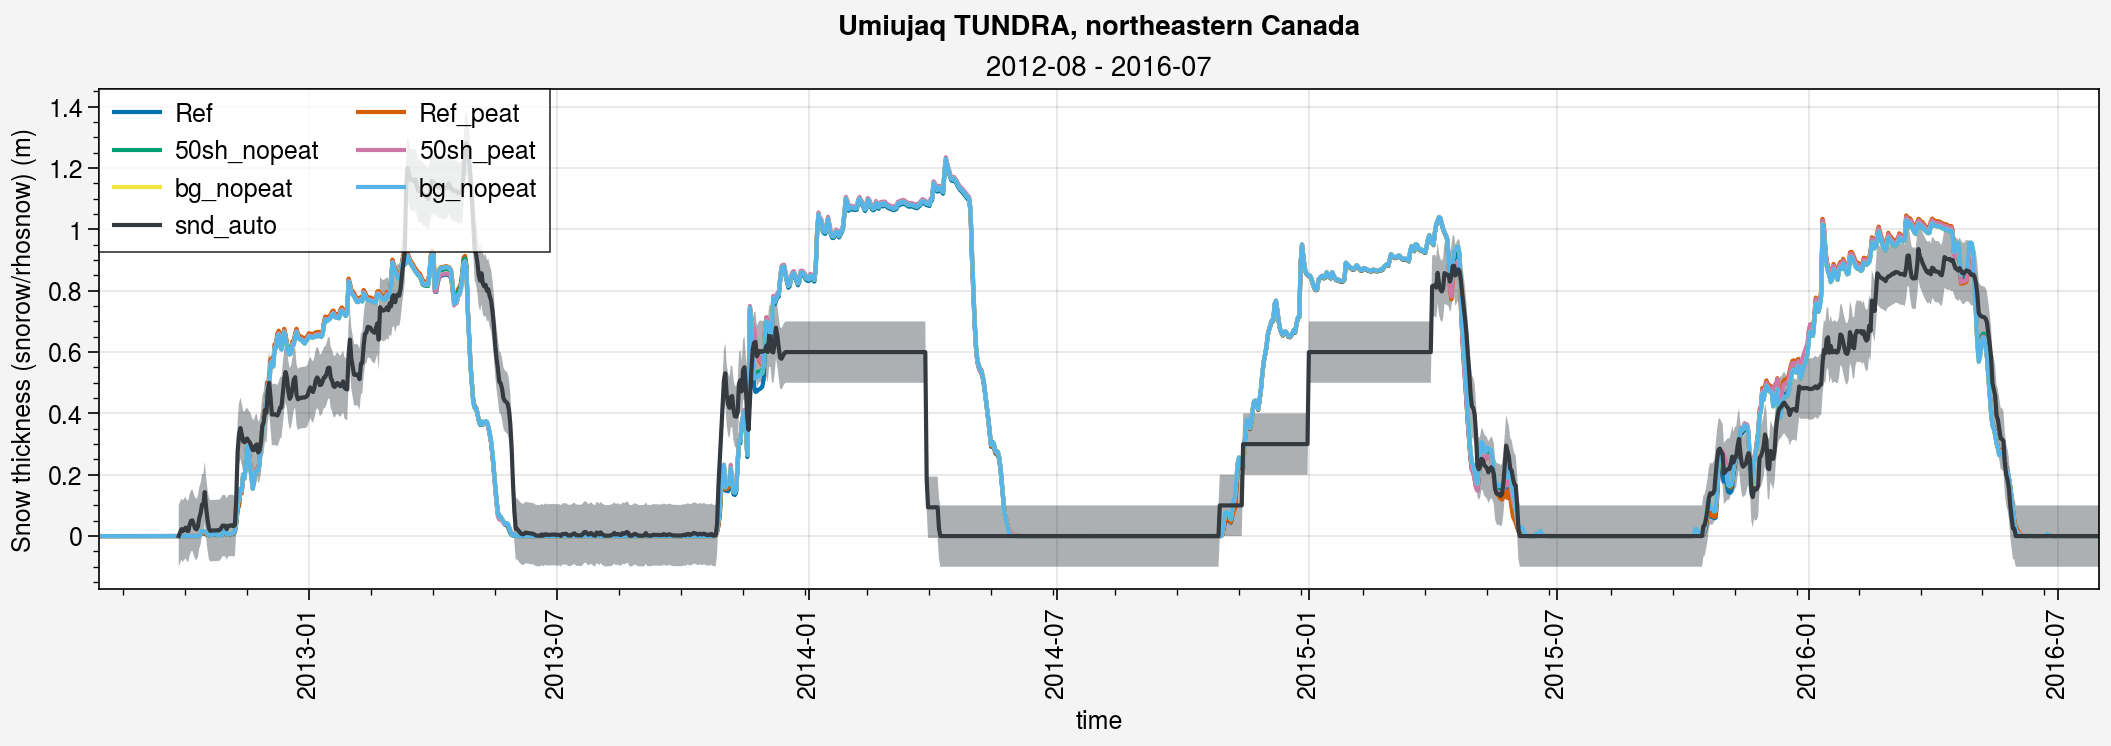

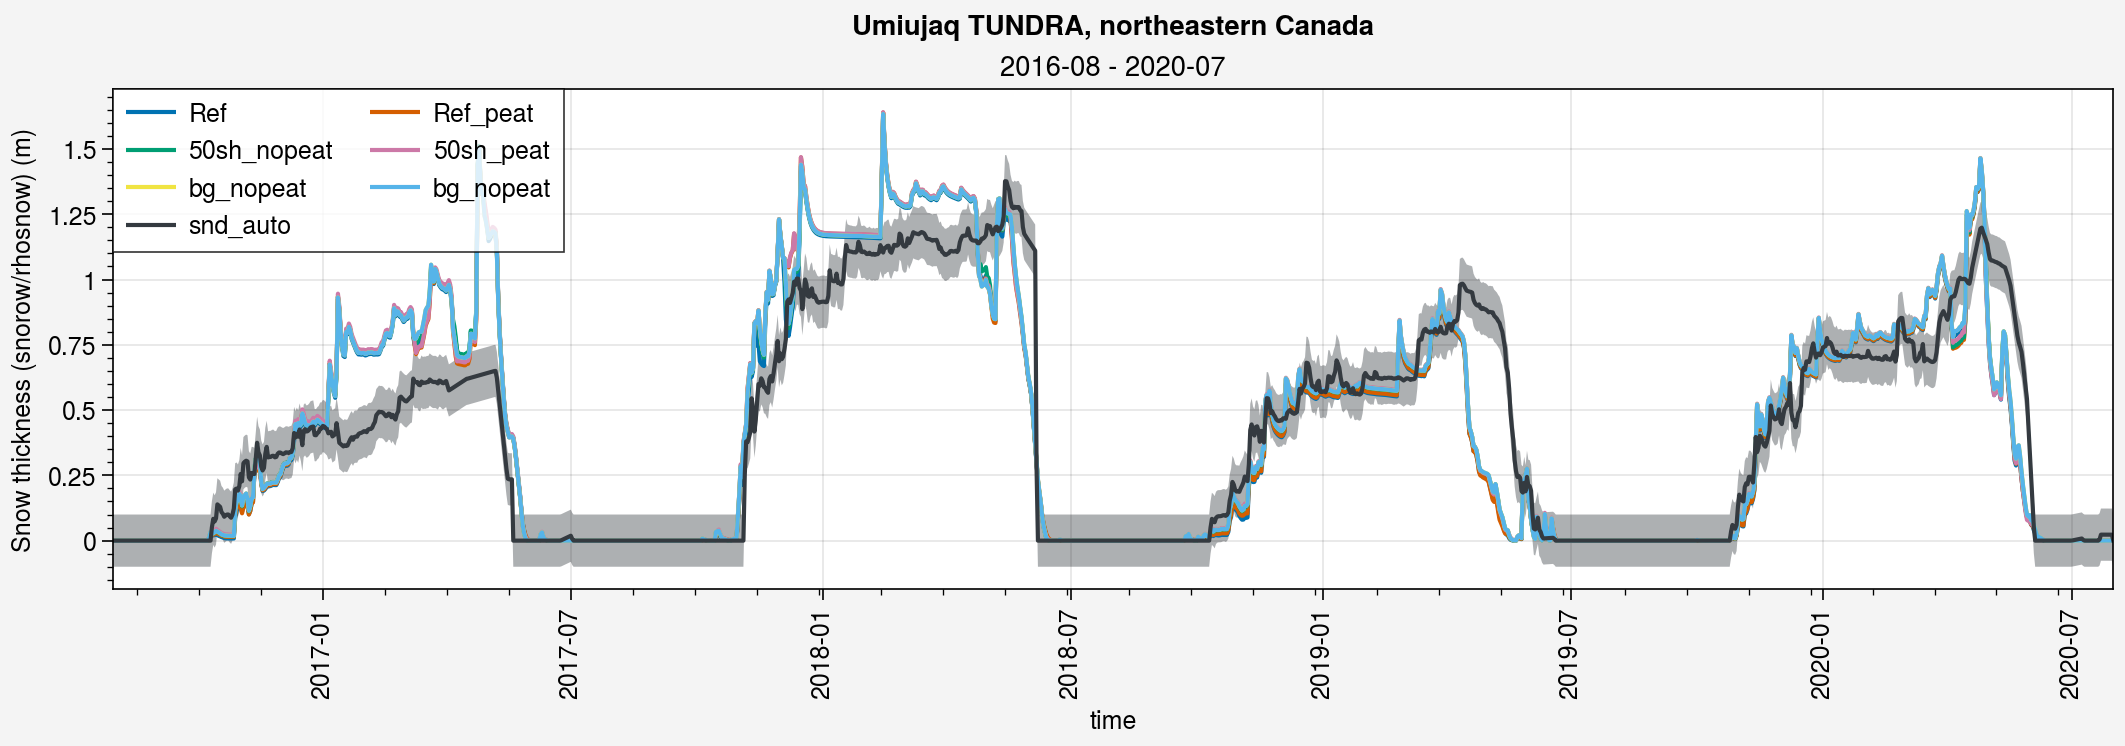

In [43]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.snd.sel(time=period), label=label)
    
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
        np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
    axs[0].plot(ds_d_obs.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    # axs[0].plot(ds_d_obs.snd_man.sel(time=period), marker='.', color=color_obs)

    # Veg
    # axs[0].plot(ds_d_list[0].vegHeight.sel(time=period), label='vegHeight', color='green', ls='-', lw=0.5, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop)
    
    fig.suptitle(site_longname)
    # fig.save('bylot_snd.pdf')

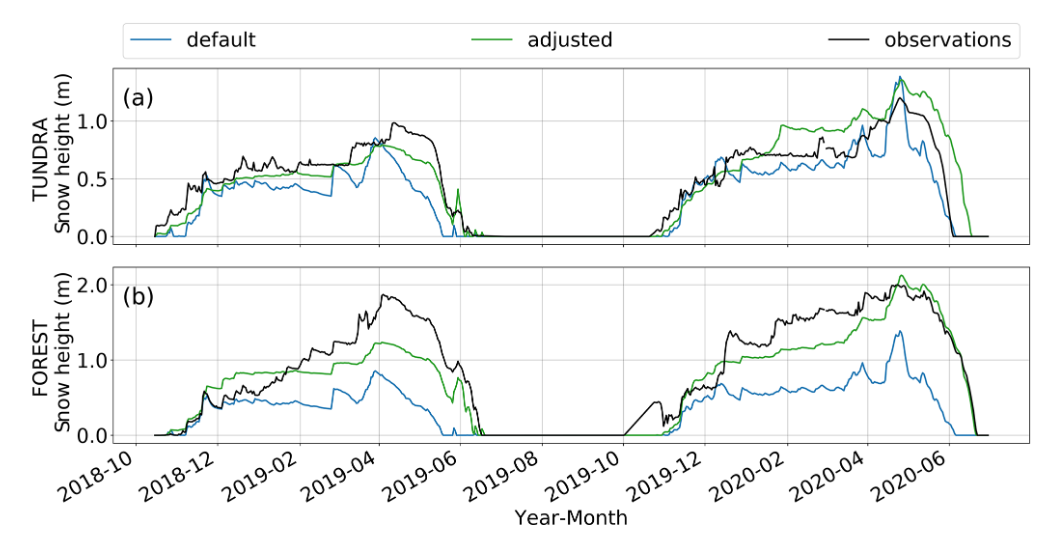

### SWE

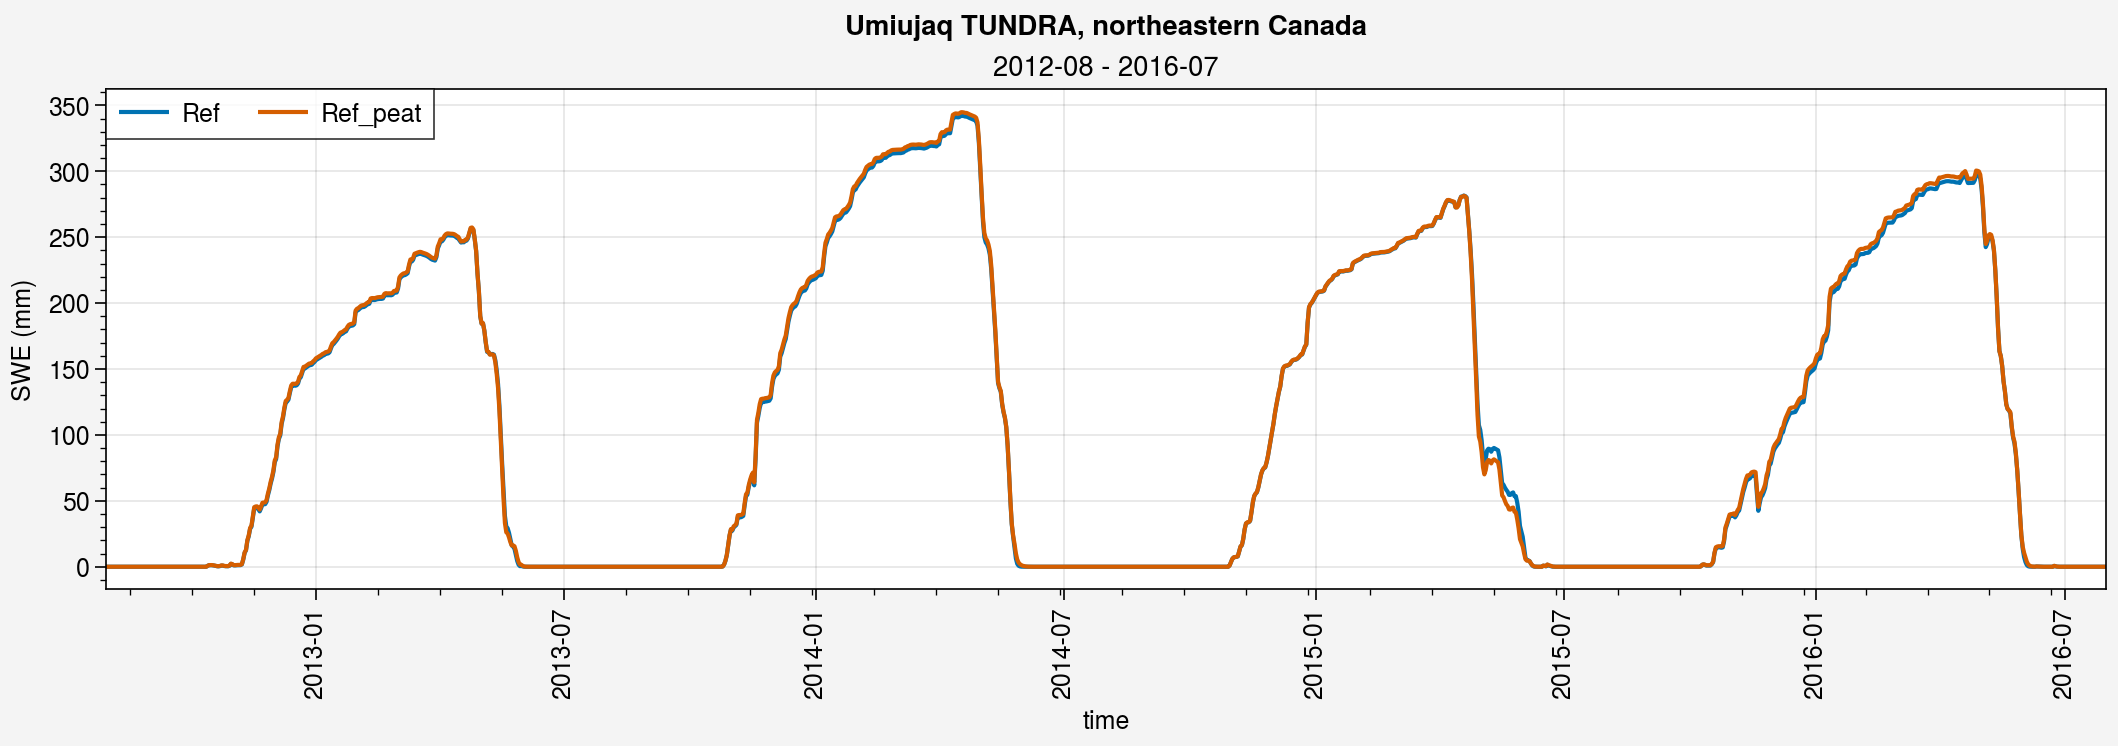

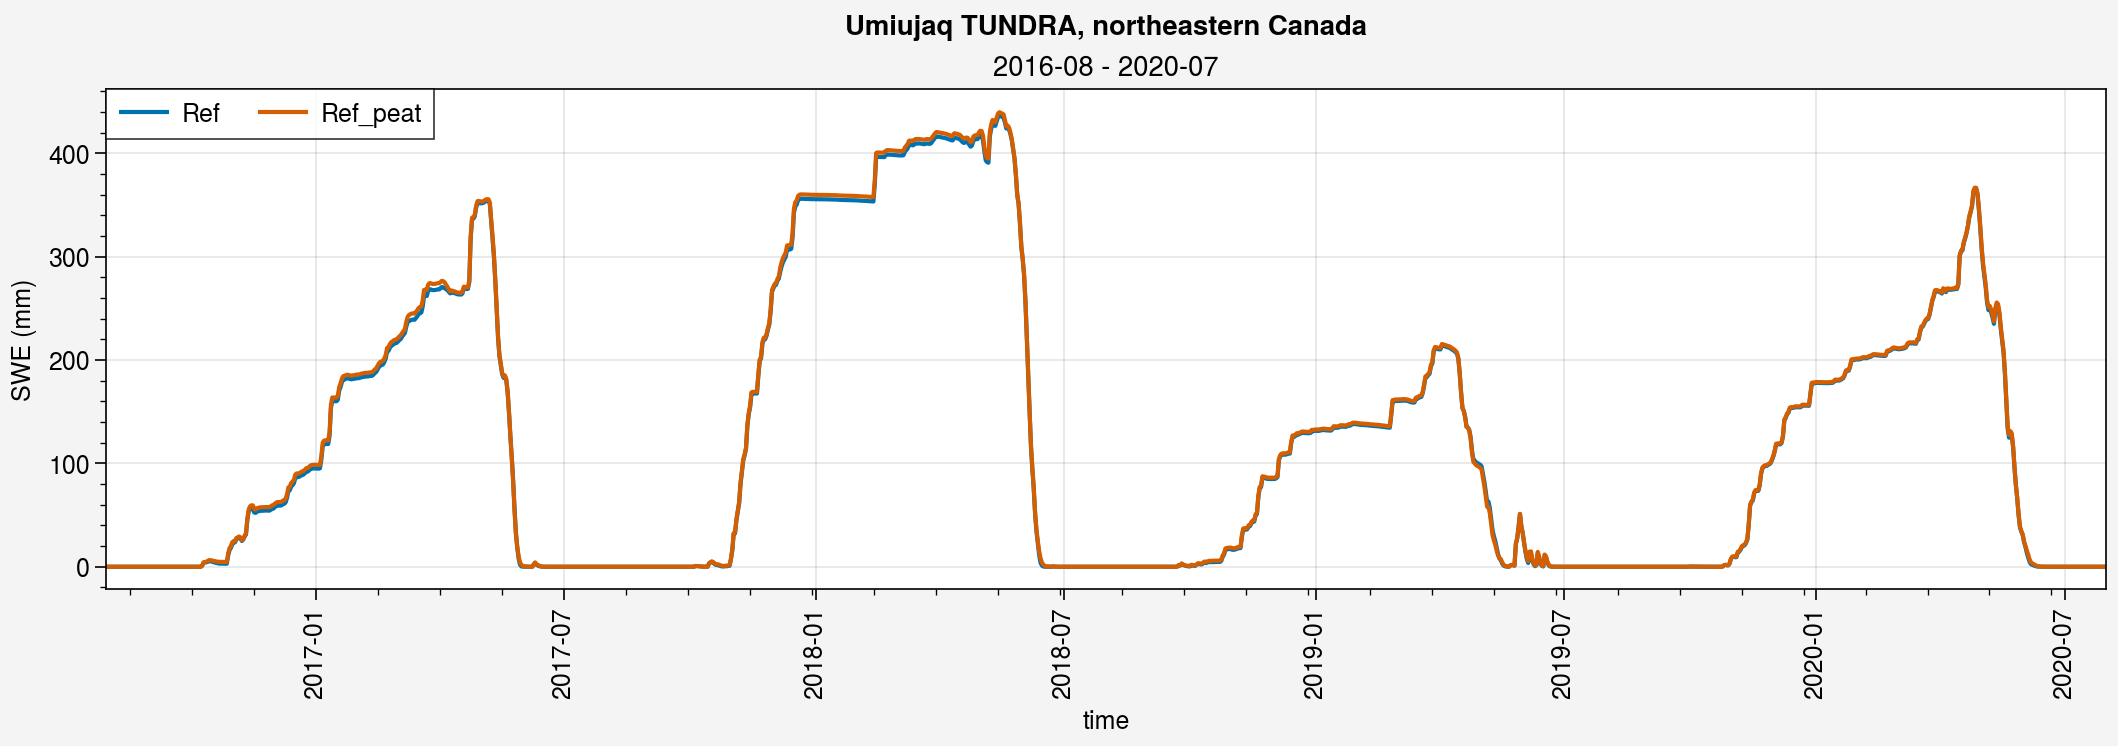

In [19]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.snw.sel(time=period), label=label)
    
    # Obs
    # shadedata = np.concatenate((
    #     np.expand_dims(ds_d_obs.snw_auto.sel(time=period).values+25, axis=0),
    #     np.expand_dims(ds_d_obs.snw_auto.sel(time=period).values-25, axis=0),), axis=0)
    # axs[0].plot(ds_d_obs.snw_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    # axs[0].plot(ds_d_obs.snw_man.sel(time=period), marker='.', color=color_obs)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='SWE (mm)')
    
    fig.suptitle(site_longname)


### Albedo

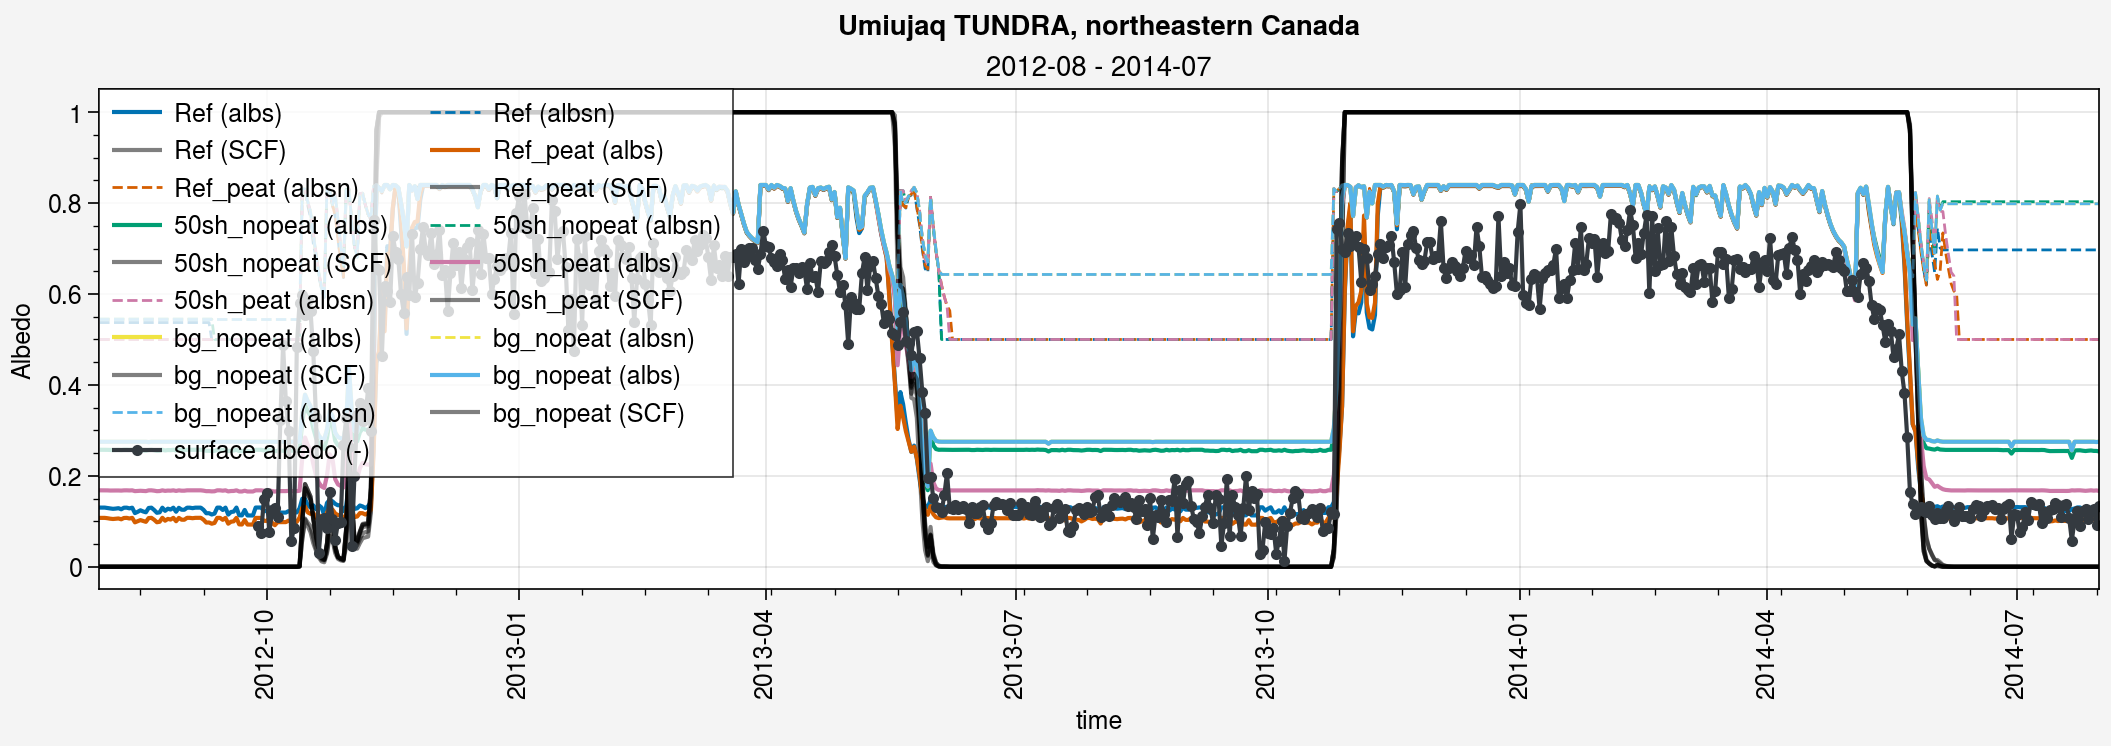

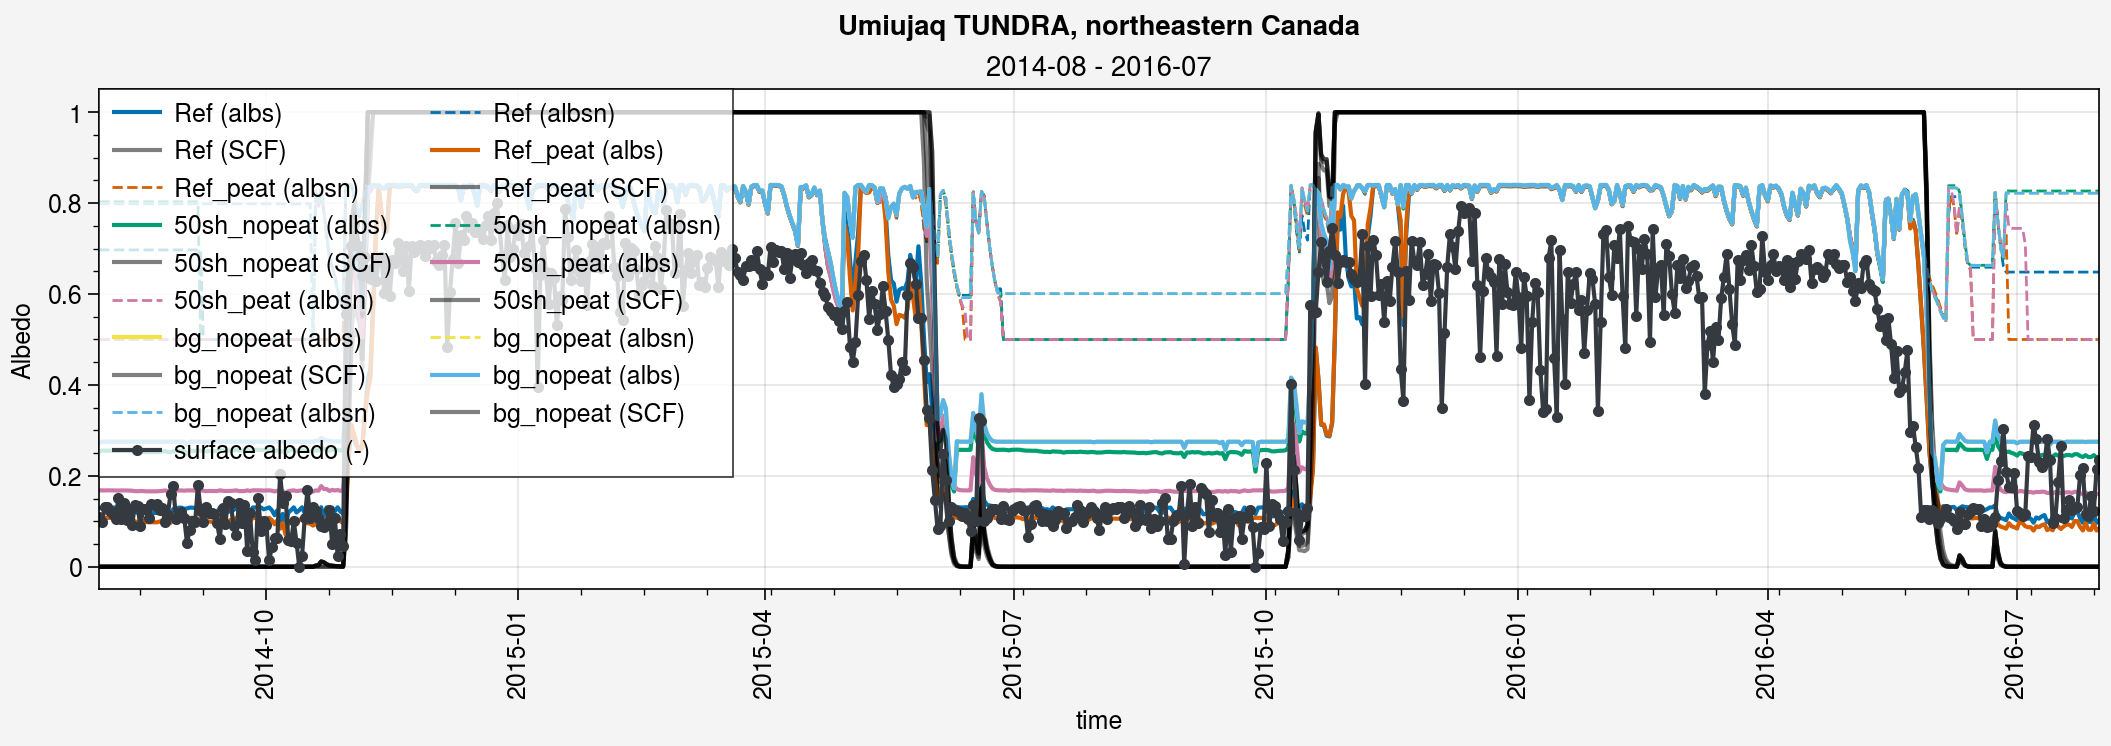

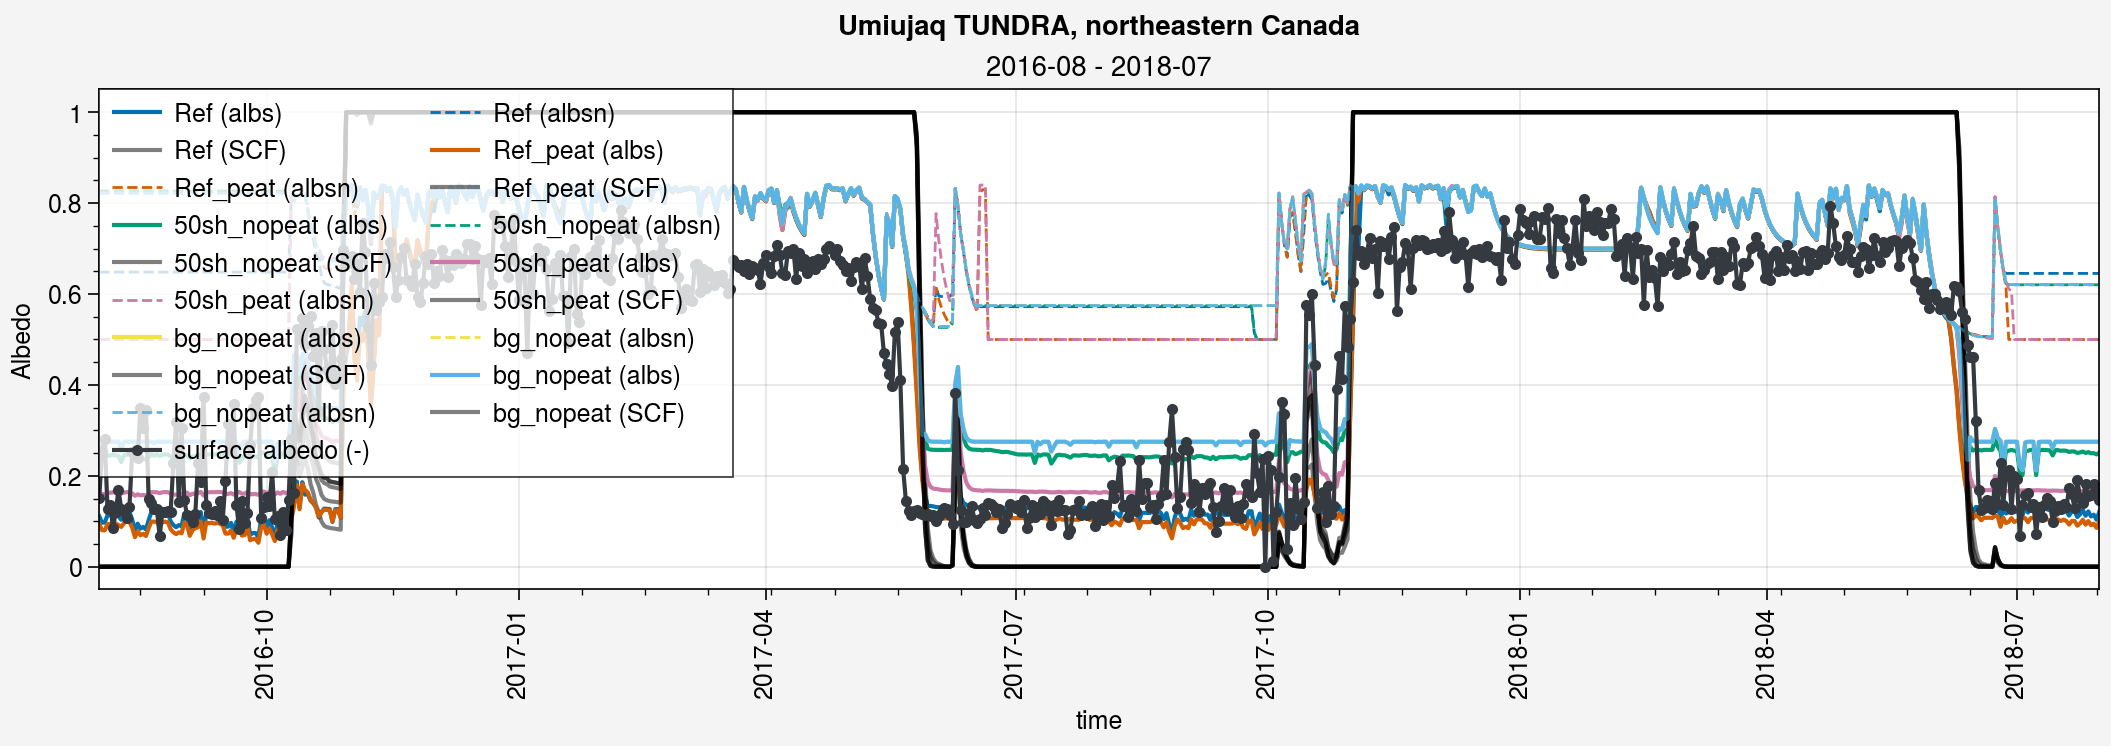

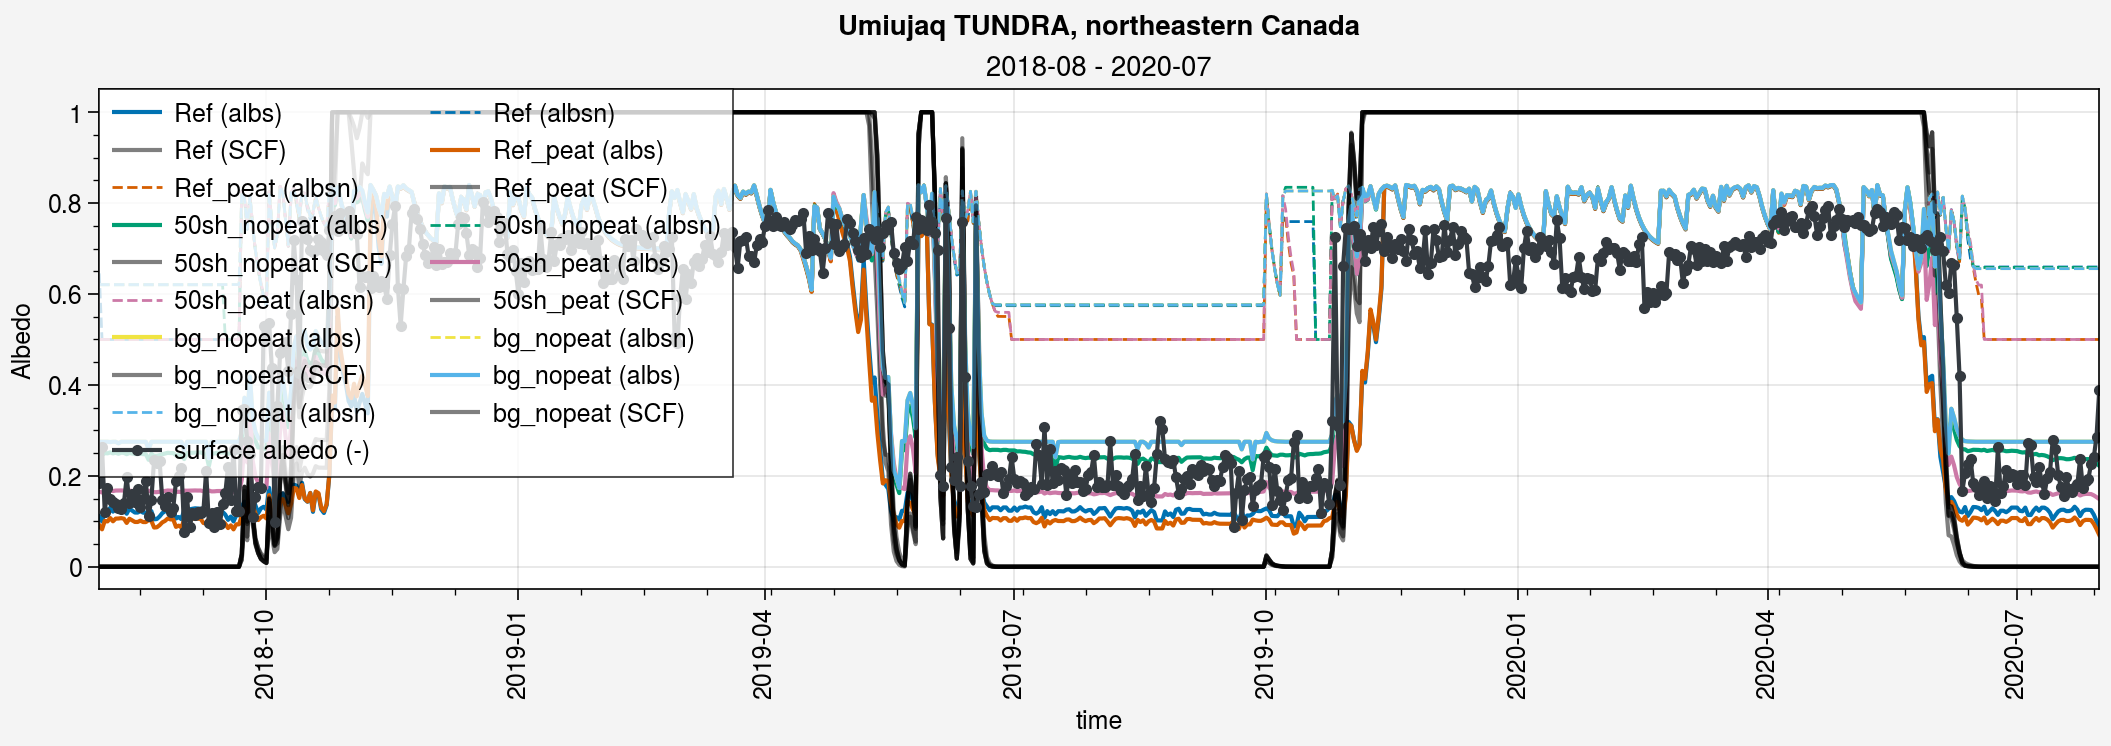

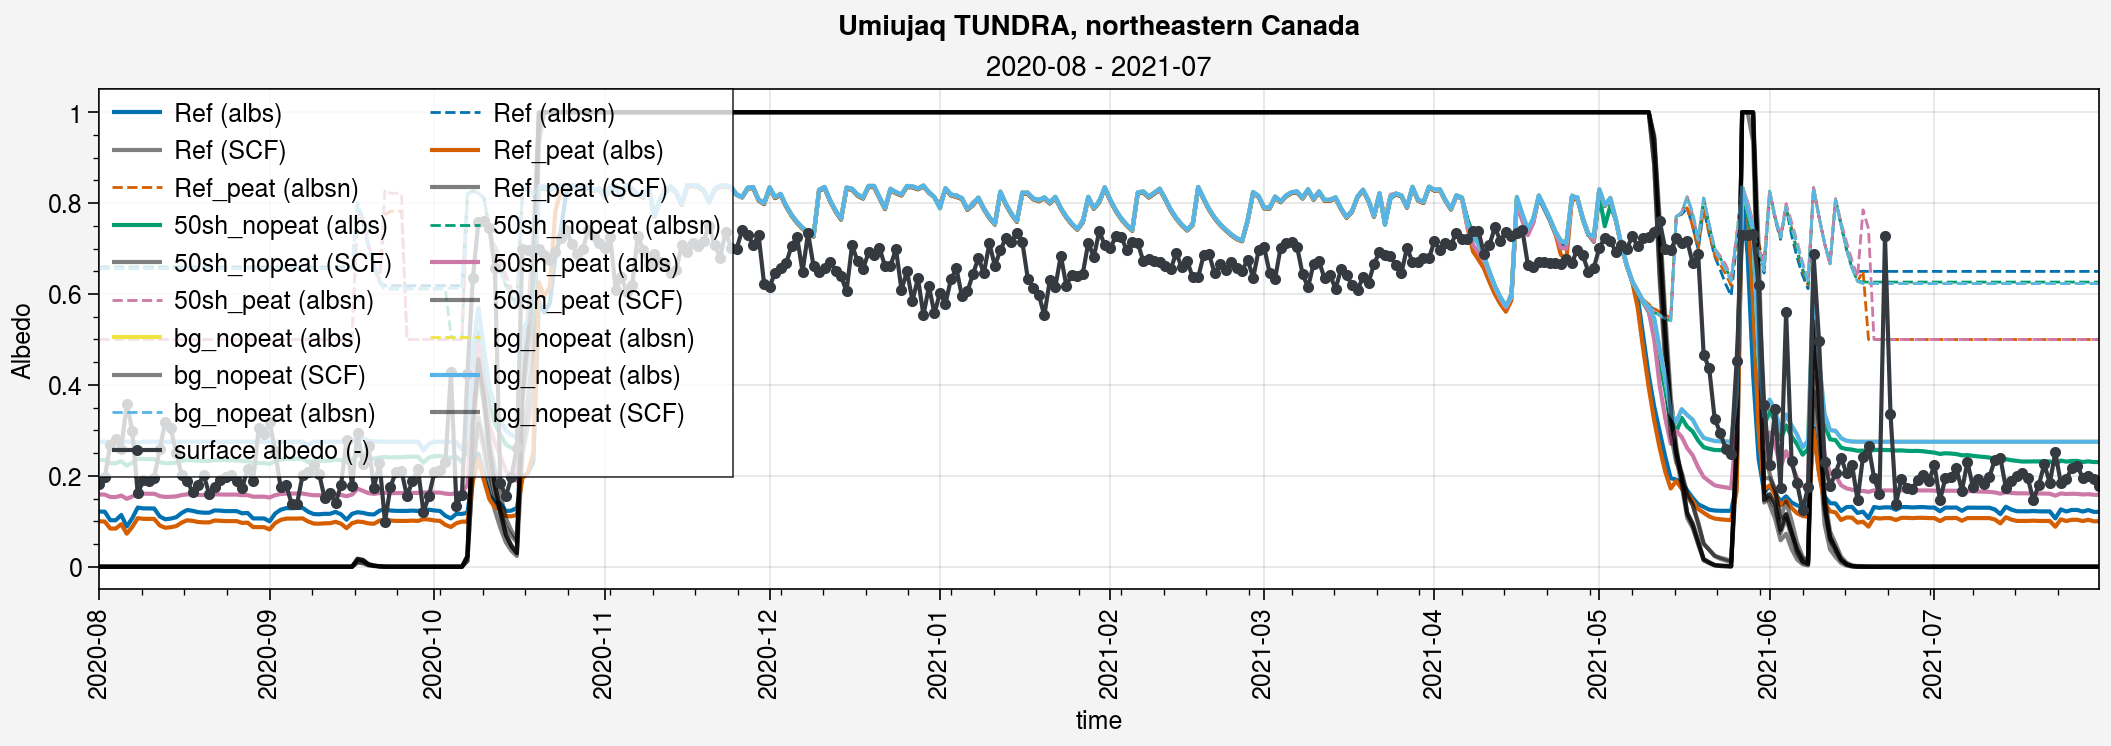

In [44]:
%matplotlib inline
gap = 2
color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    k = 0
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.albs.sel(time=period), label=label+' (albs)', color='C'+str(k))
        axs[0].plot(ds_d.albsn.sel(time=period), label=label+' (albsn)', color='C'+str(k), ls='--', lw=1)
        axs[0].plot(ds_d.snc.sel(time=period), label=label+' (SCF)', color='k', alpha=0.5)
        
        k+=1
    
    # Obs
    axs[0].plot(ds_d_obs.albs.sel(time=period), marker='.', color=color_obs)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Albedo')
    
    fig.suptitle(site_longname)


### Surface Temperature

Domine et al. ([2019](https://onlinelibrary.wiley.com/doi/abs/10.1029/2018MS001445)): "**Averaged over a period of several days the surface temperatures are essentially the same**. The amplitude variations are greater in the Alpine snowpack (Figure 8b) because the insulating layer at the top does not allow damping the air temperature variations by heat exchanges with the snowpack. This effect is more important in April and May, when daily temperature variations reach 20 °C, sometimes more. The absolute temperature differences reaches 4.7 °C on 8 February, when the temperature suddenly increases by 15 °C in 5 hr, and the surface temperature of the Alpine snowpack increases more rapidly."

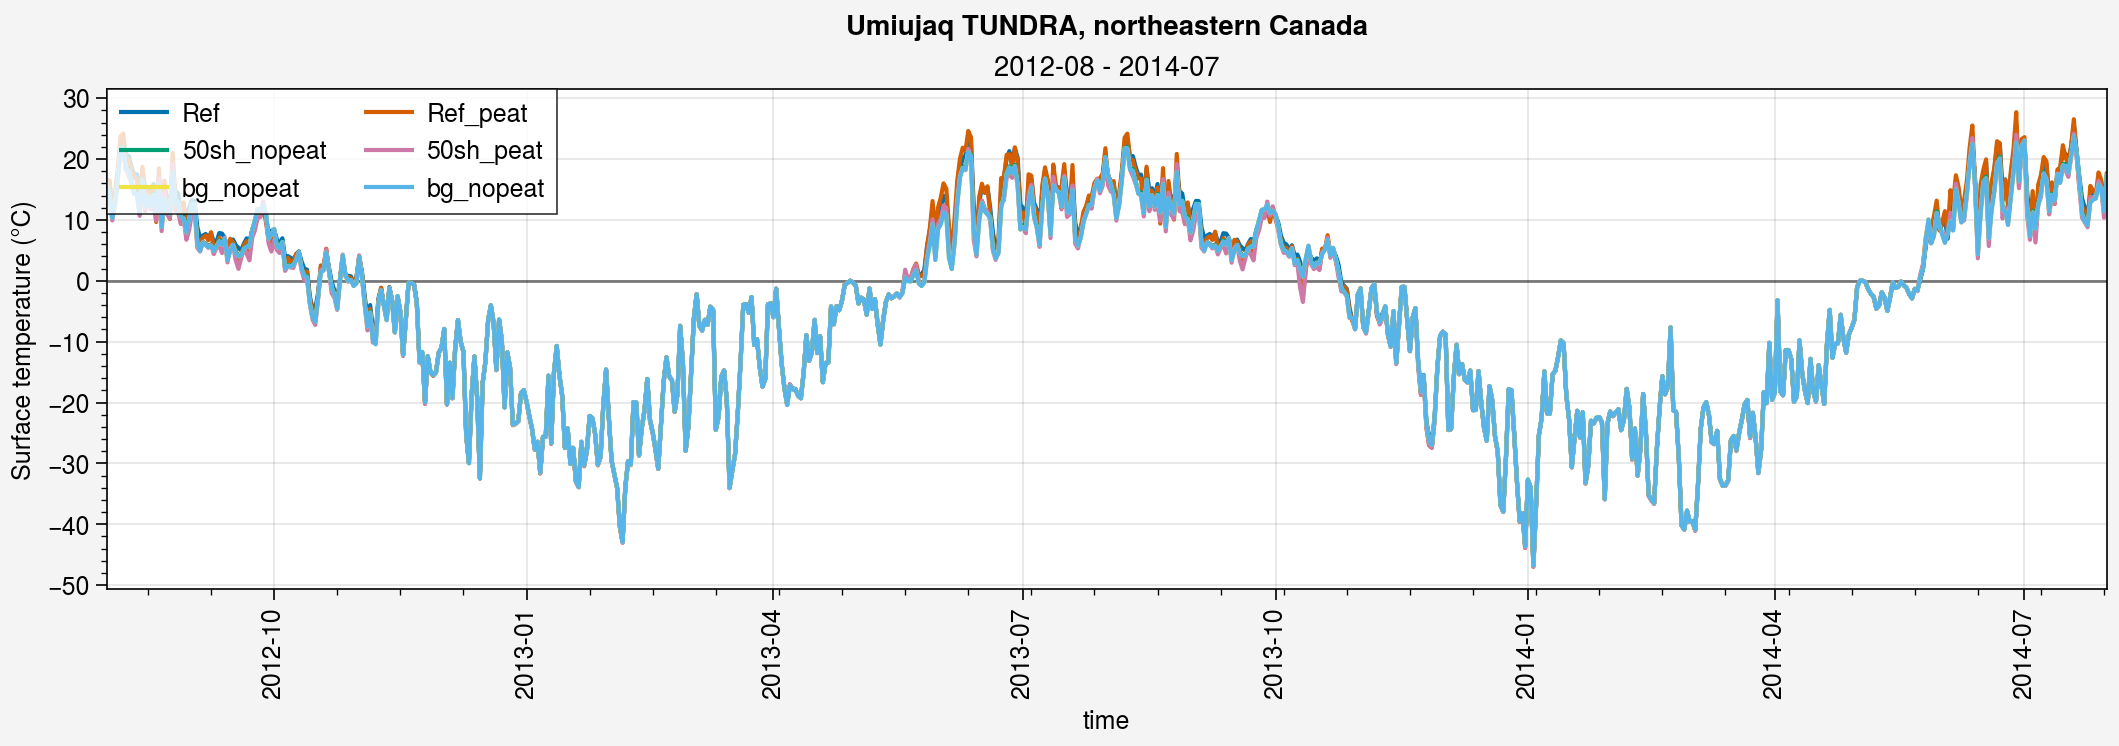

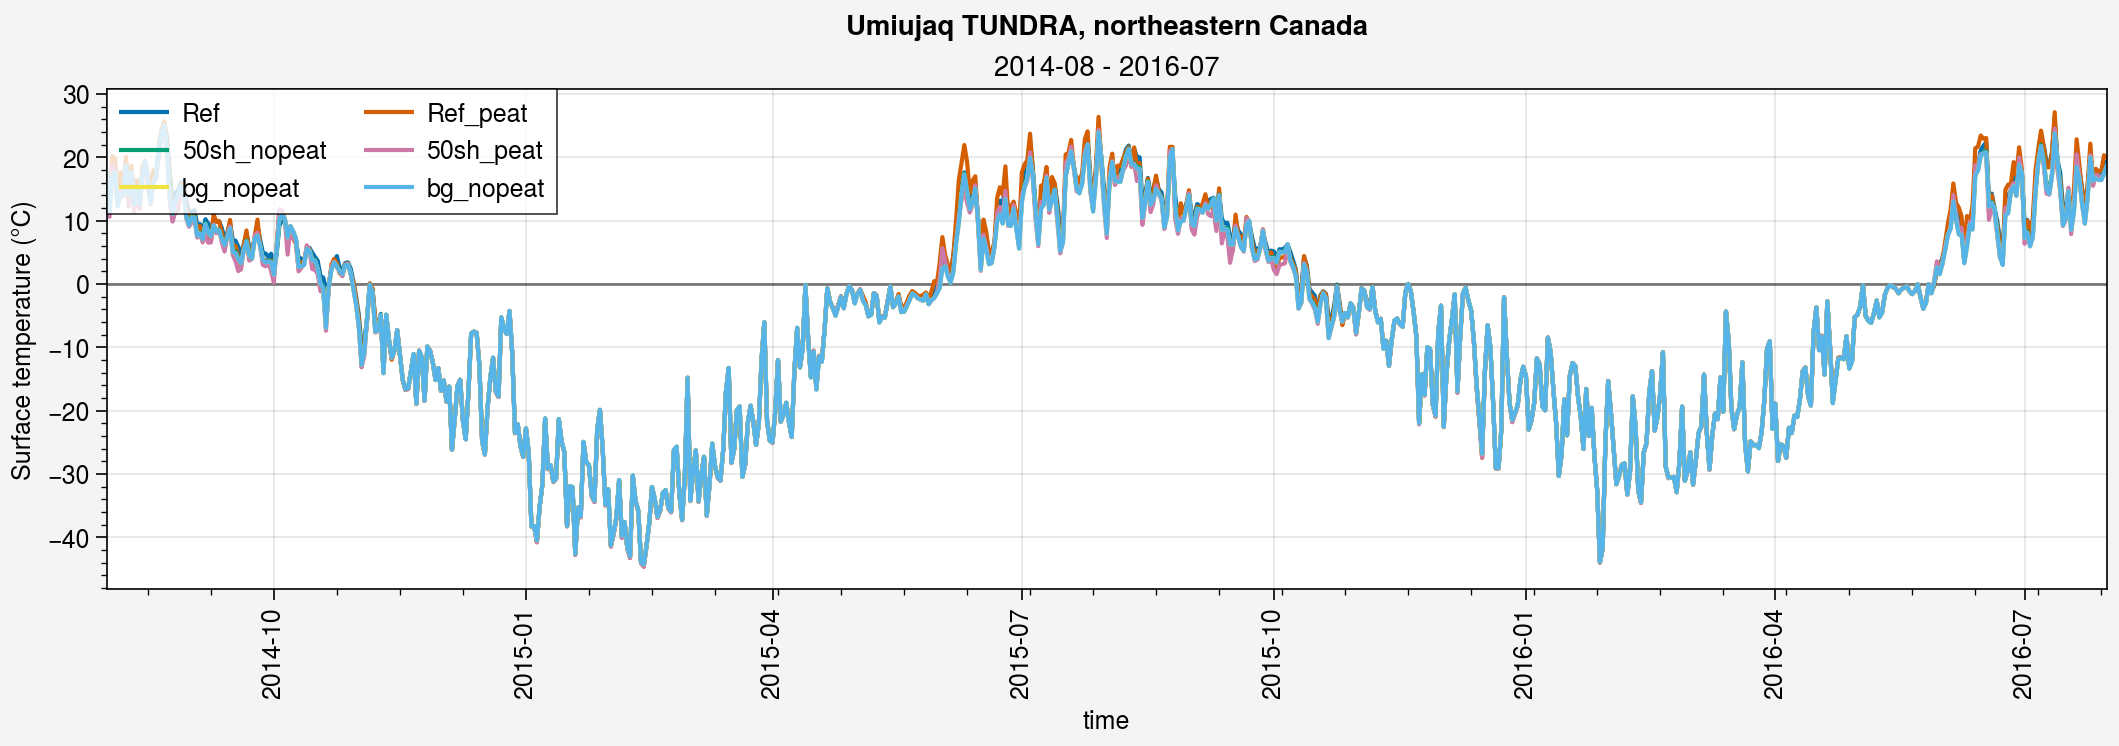

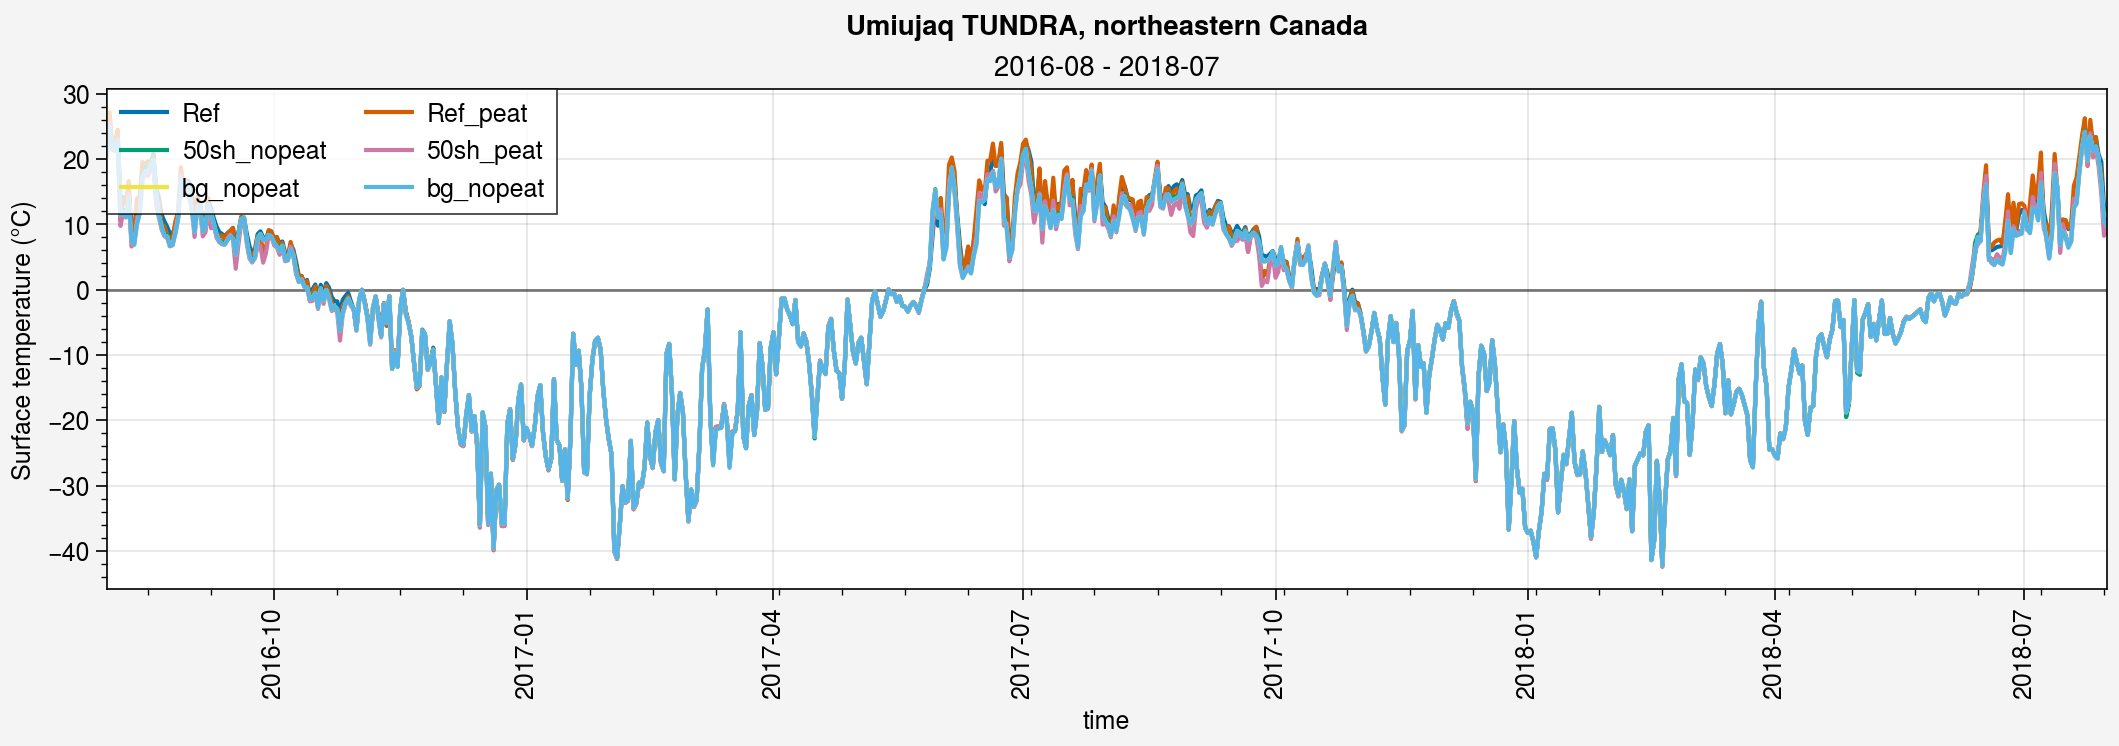

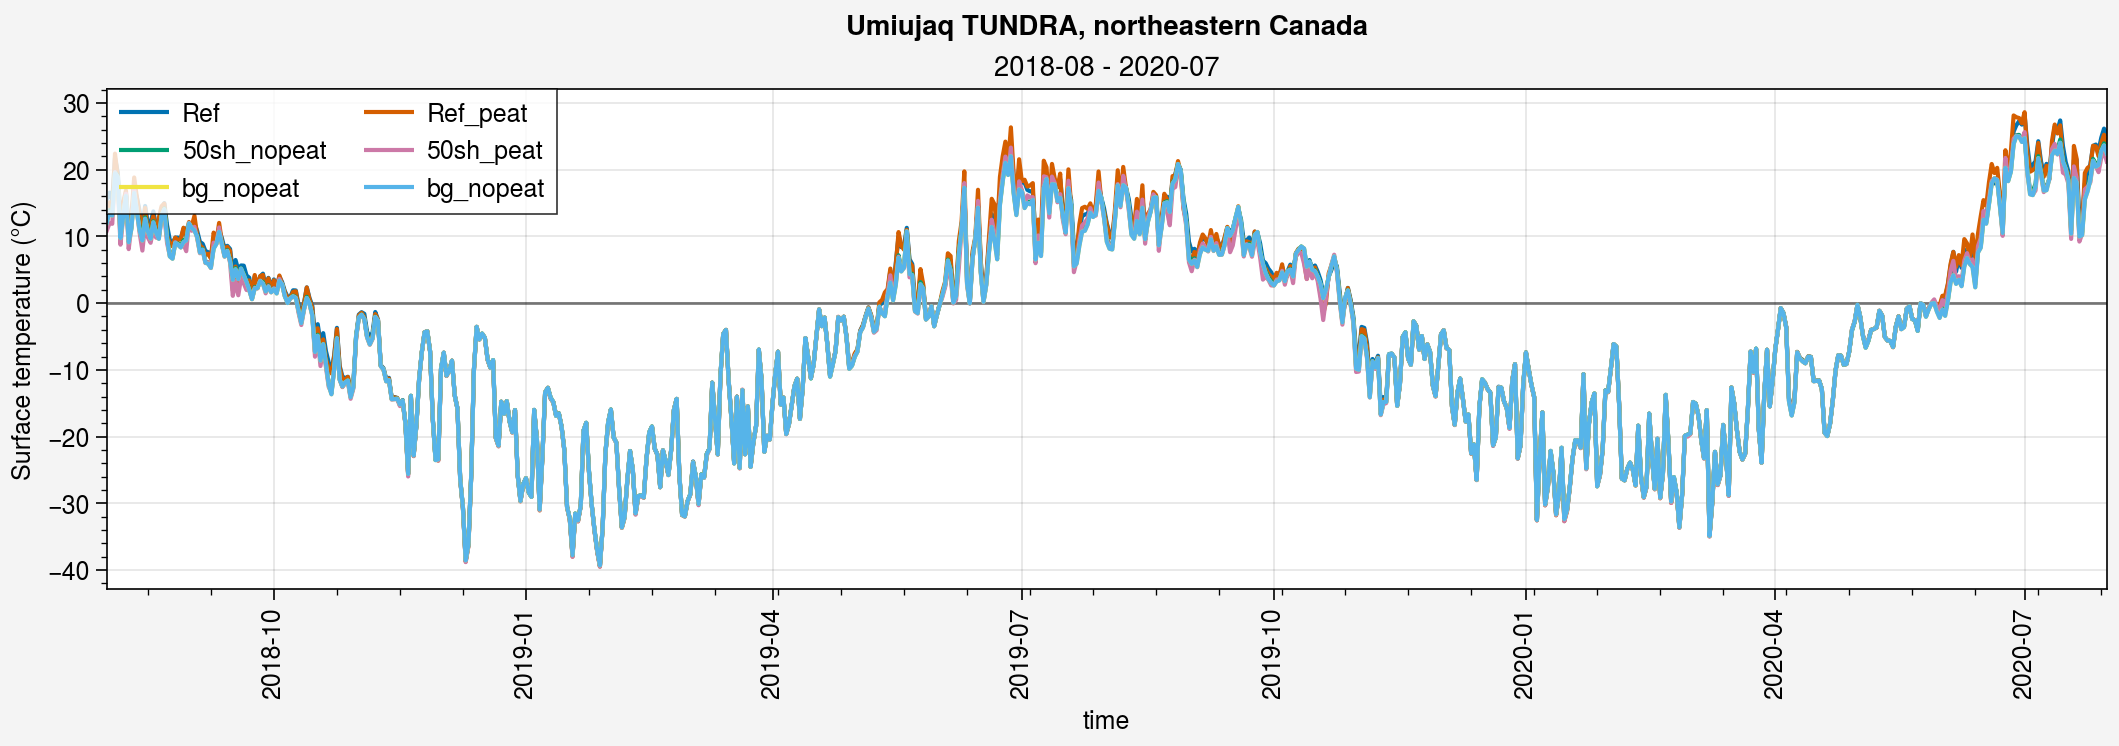

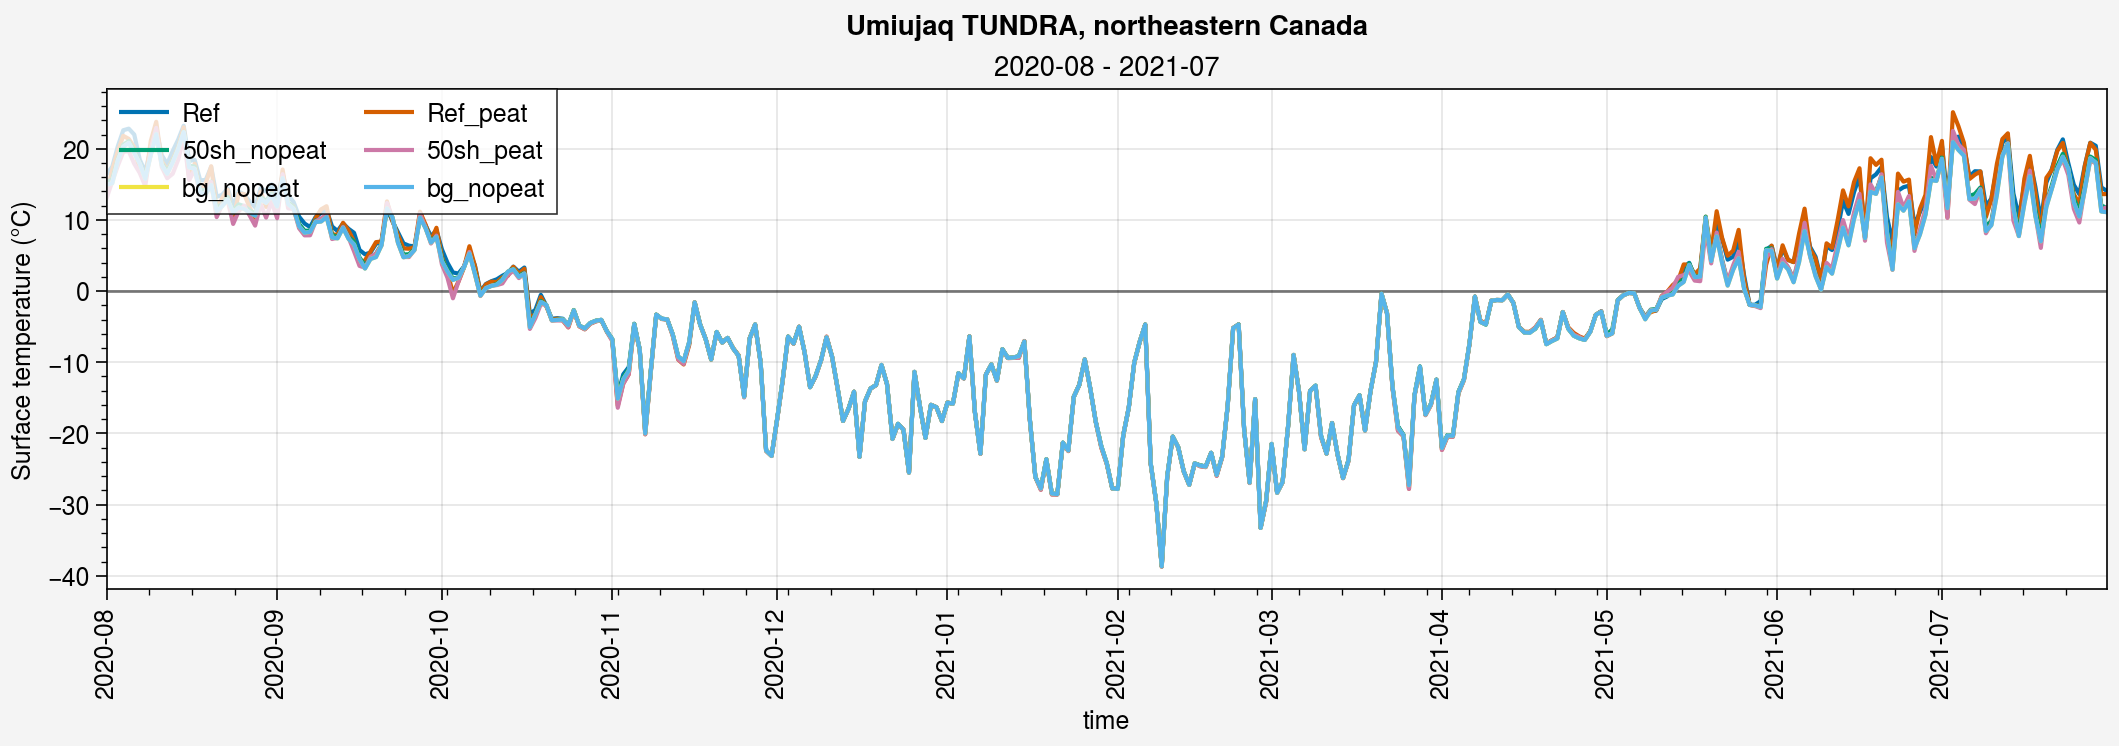

In [45]:
%matplotlib inline
gap = 2
color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.ts.sel(time=period)-273.15, label=label)
    
    # Obs
    # axs[0].plot(ds_d_obs.ts.sel(time=period), color=color_obs)
    axs[0].hlines(0, ds_d.ts.sel(time=period).time[0], ds_d.ts.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Surface temperature (°C)')
    
    fig.suptitle(site_longname)


### Soil Temperature

In [73]:
ds_d_obs

<xarray.Dataset>
Dimensions:   (veg: 2, sdepth: 4, time: 3309)
Coordinates:
  * veg       (veg) object 'lichen' 'lowshrub'
  * sdepth    (sdepth) float64 0.15 0.25 0.35 0.45
  * time      (time) datetime64[ns] 2012-09-28 2012-09-29 ... 2021-10-19
Data variables:
    snd_auto  (time) float64 0.0 0.01196 0.02252 ... 0.03703 0.05901 0.0582
    mrsll     (time, veg, sdepth) float64 nan nan nan nan ... nan nan nan nan
    tsl       (time, veg, sdepth) float64 nan nan nan nan ... nan nan nan nan
    albs      (time) float64 0.08978 0.0732 0.1486 ... 0.1283 0.119 0.1677
Attributes:
    event:          Umiujaq_2012-2021_Tundra
    link:           https://doi.pangaea.de/10.1594/PANGAEA.964743
    downloaded:     27/02/2024 by Mickaël Lalande
    original_file:  Domine-etal_2024/datasets/Umiujaq_snow_height.tab, Umiuja...

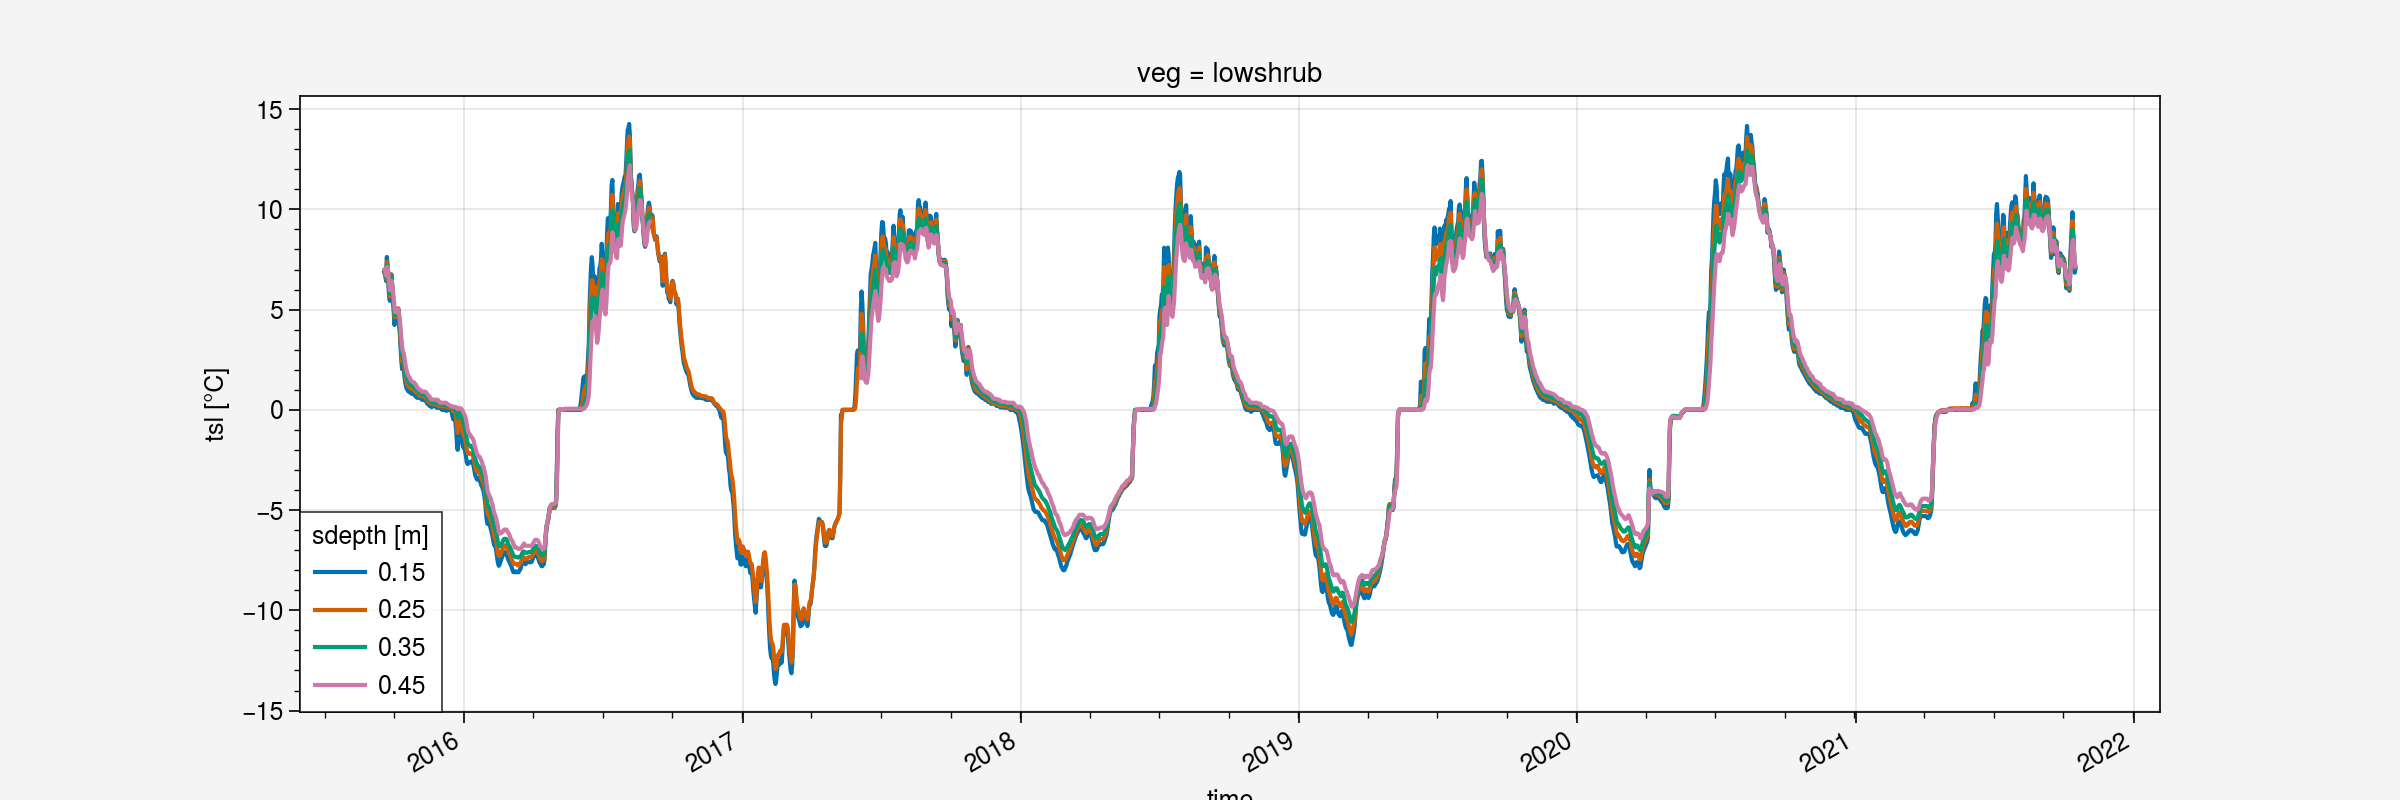

In [75]:
%matplotlib inline
ds_d_obs.tsl.sel(veg='lowshrub').plot(hue='sdepth', figsize=(12, 4))

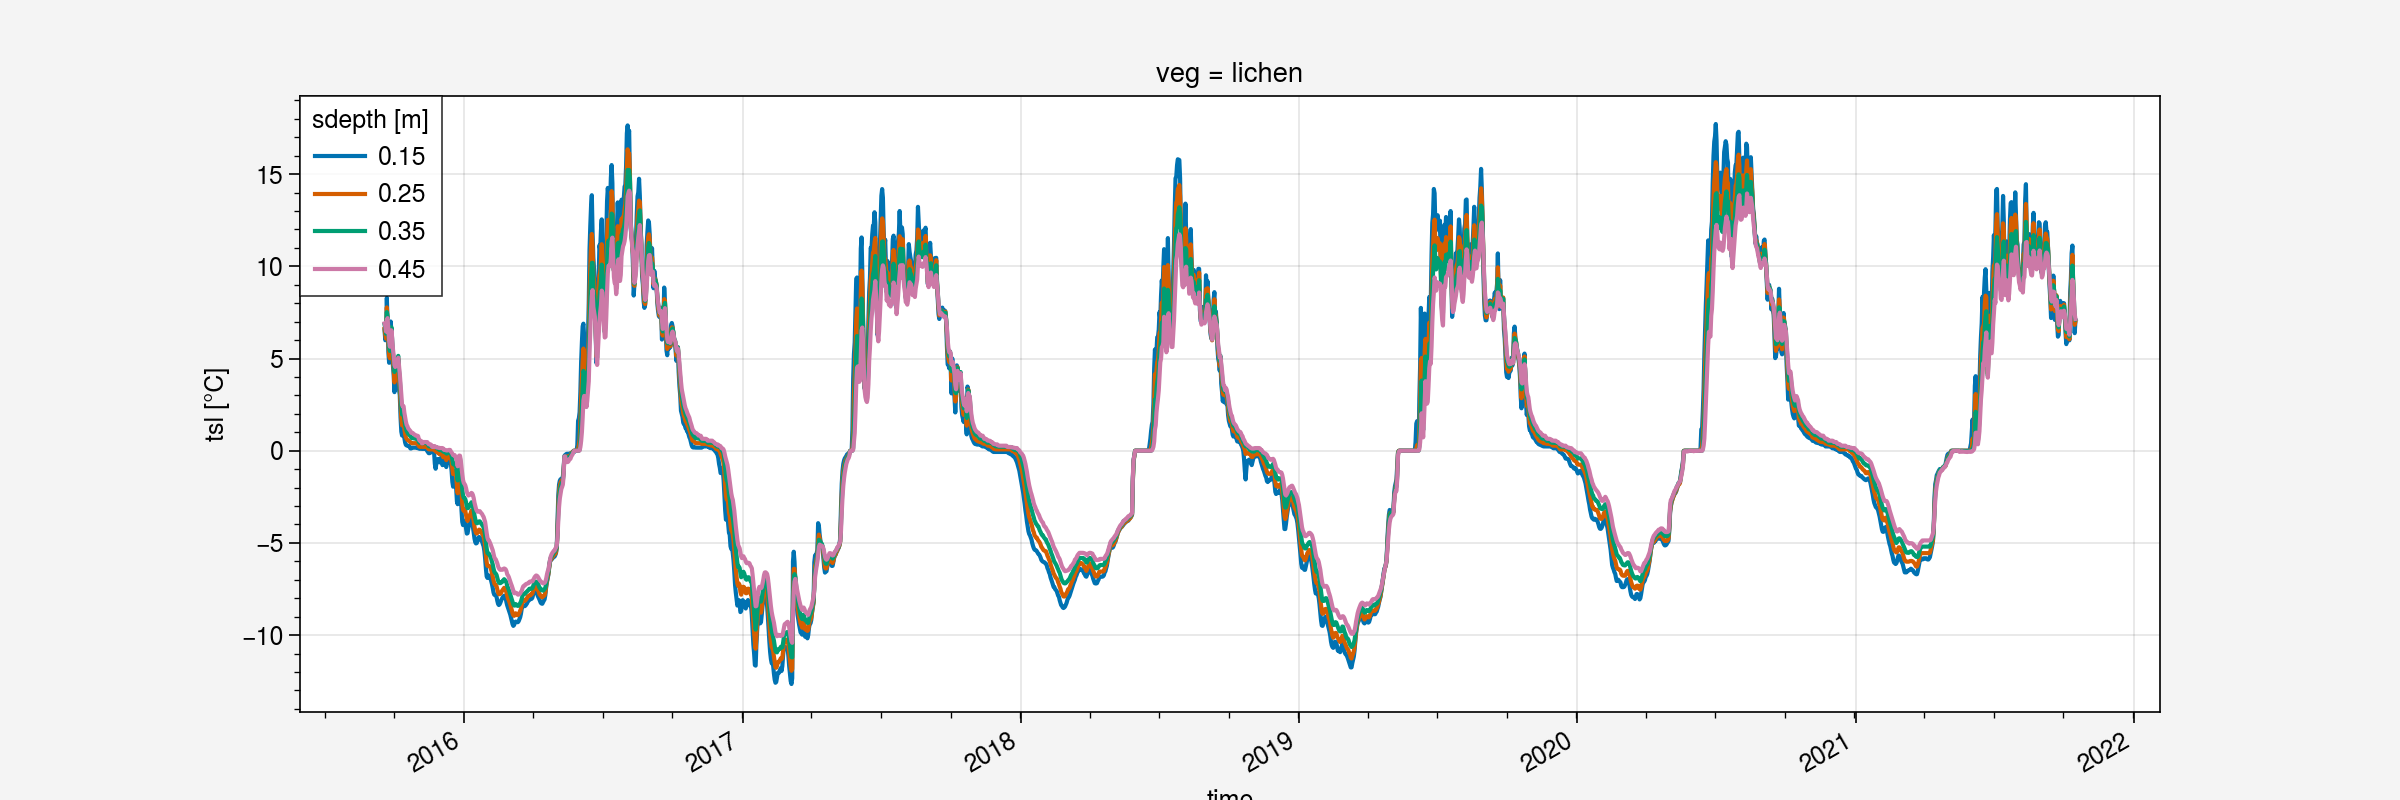

In [76]:
%matplotlib inline
ds_d_obs.tsl.sel(veg='lichen').plot(hue='sdepth', figsize=(12, 4))

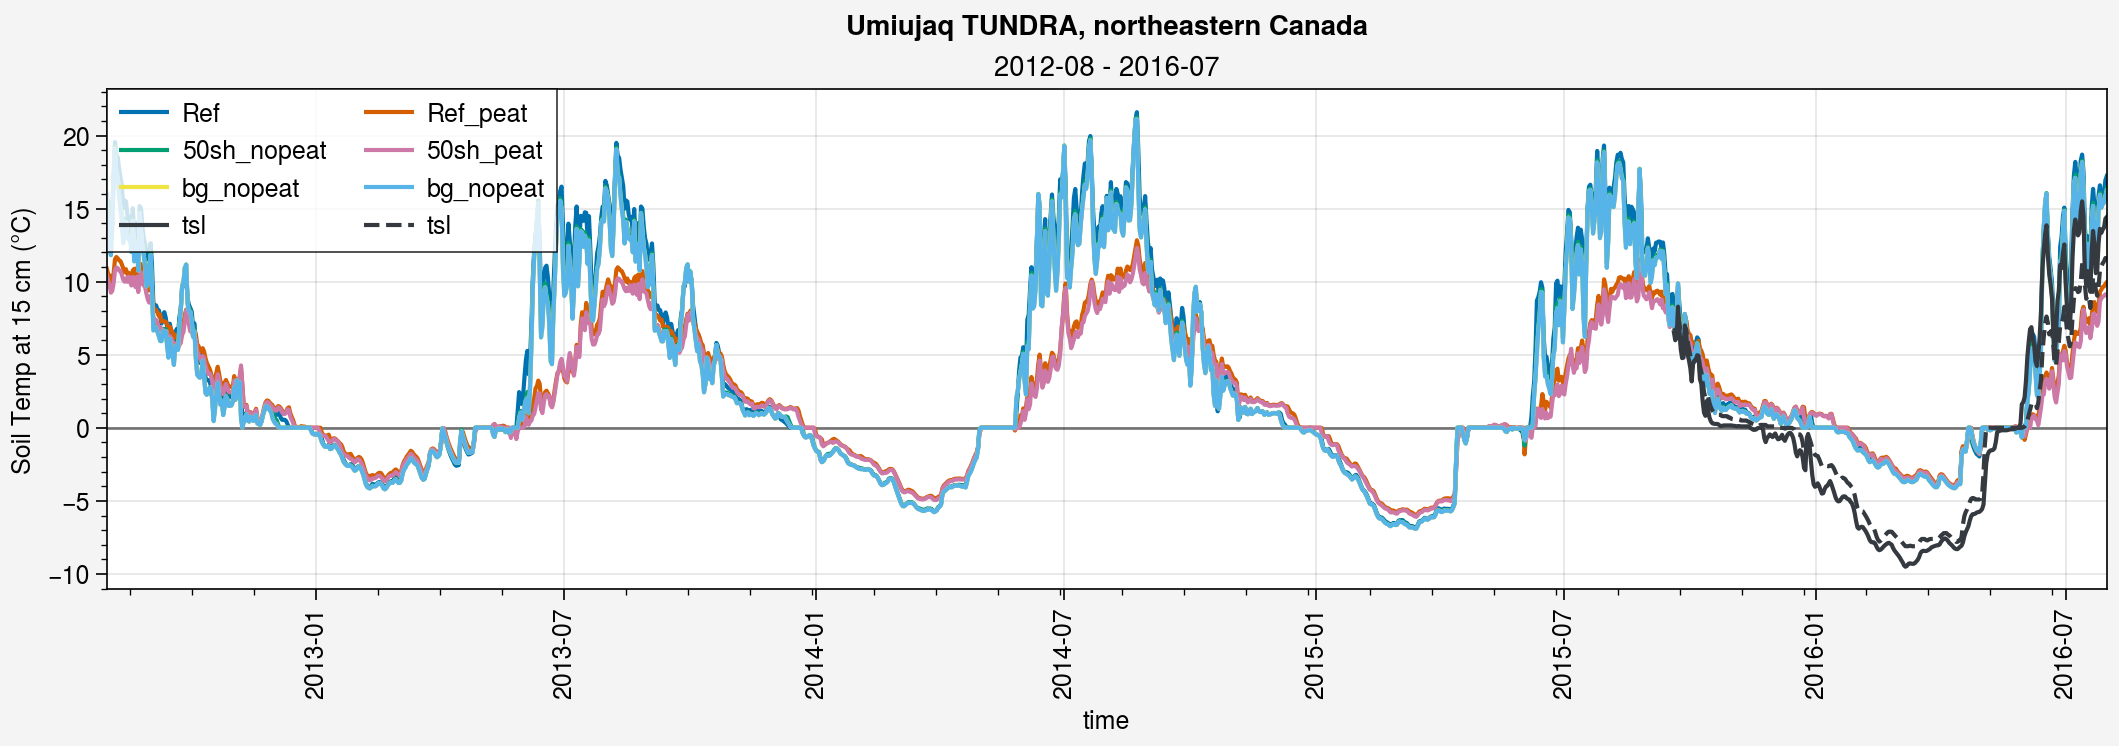

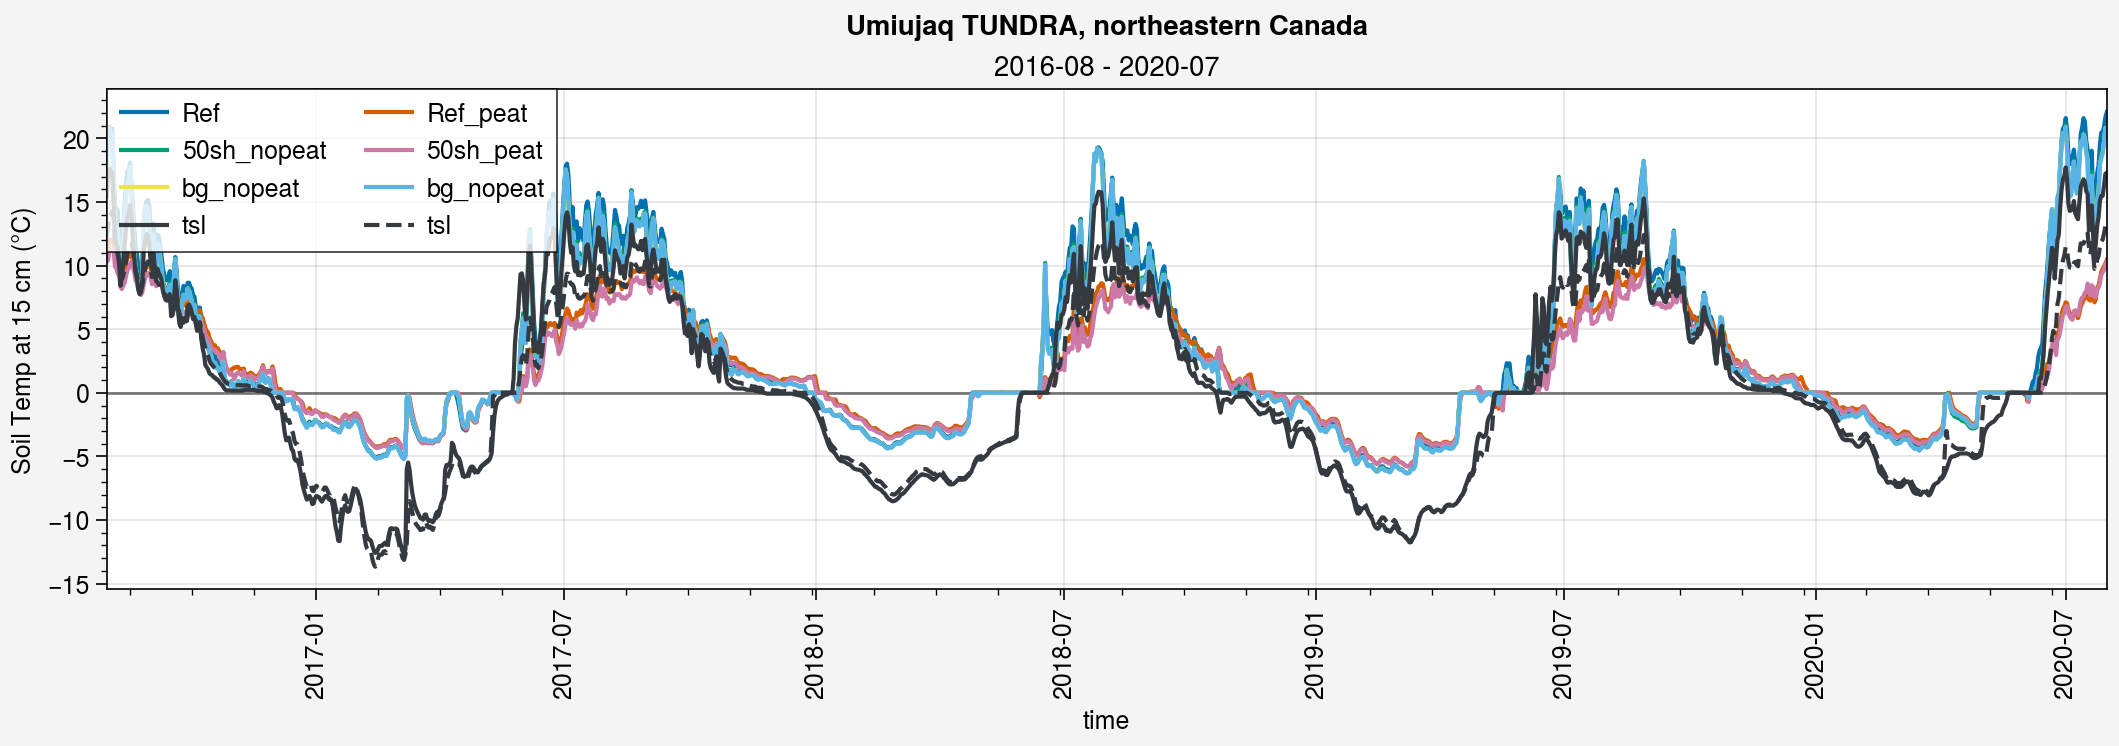

In [46]:
%matplotlib inline
gap = 4
color_obs = 'gray8'
sdepth = 0.15
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        # axs[0].plot(((ds_d.tsl.sel(time=period, layer=1)+ds_d.tsl.sel(time=period, layer=2))/2)-273.15, label=label)
        # axs[0].plot(((ds_d.tsl.sel(time=period).isel(layer=0)+ds_d.tsl.sel(time=period).isel(layer=1))/2)-273.15, label=label)
        # axs[0].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1)-273.15, label=label)
        axs[0].plot(ds_d.tsl.sel(time=period).sel(layer=sdepth, method='nearest')-273.15, label=label)
        
    # Obs
    # shadedata = np.concatenate((
    #     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)+1, axis=0),
    #     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)-1, axis=0),), axis=0)
    # axs[0].plot(ds_d_obs.tsl.sel(time=period, sdepth=sdepth), shadedata=shadedata, marker='.', color=color_obs)
    axs[0].plot(ds_d_obs.tsl.sel(time=period, sdepth=sdepth, veg='lichen'), color=color_obs)
    axs[0].plot(ds_d_obs.tsl.sel(time=period, sdepth=sdepth, veg='lowshrub'), color=color_obs, ls='--')
    
    axs[0].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Soil Temp at '+sdepth_label+' cm (°C)')
    
    fig.suptitle(site_longname)


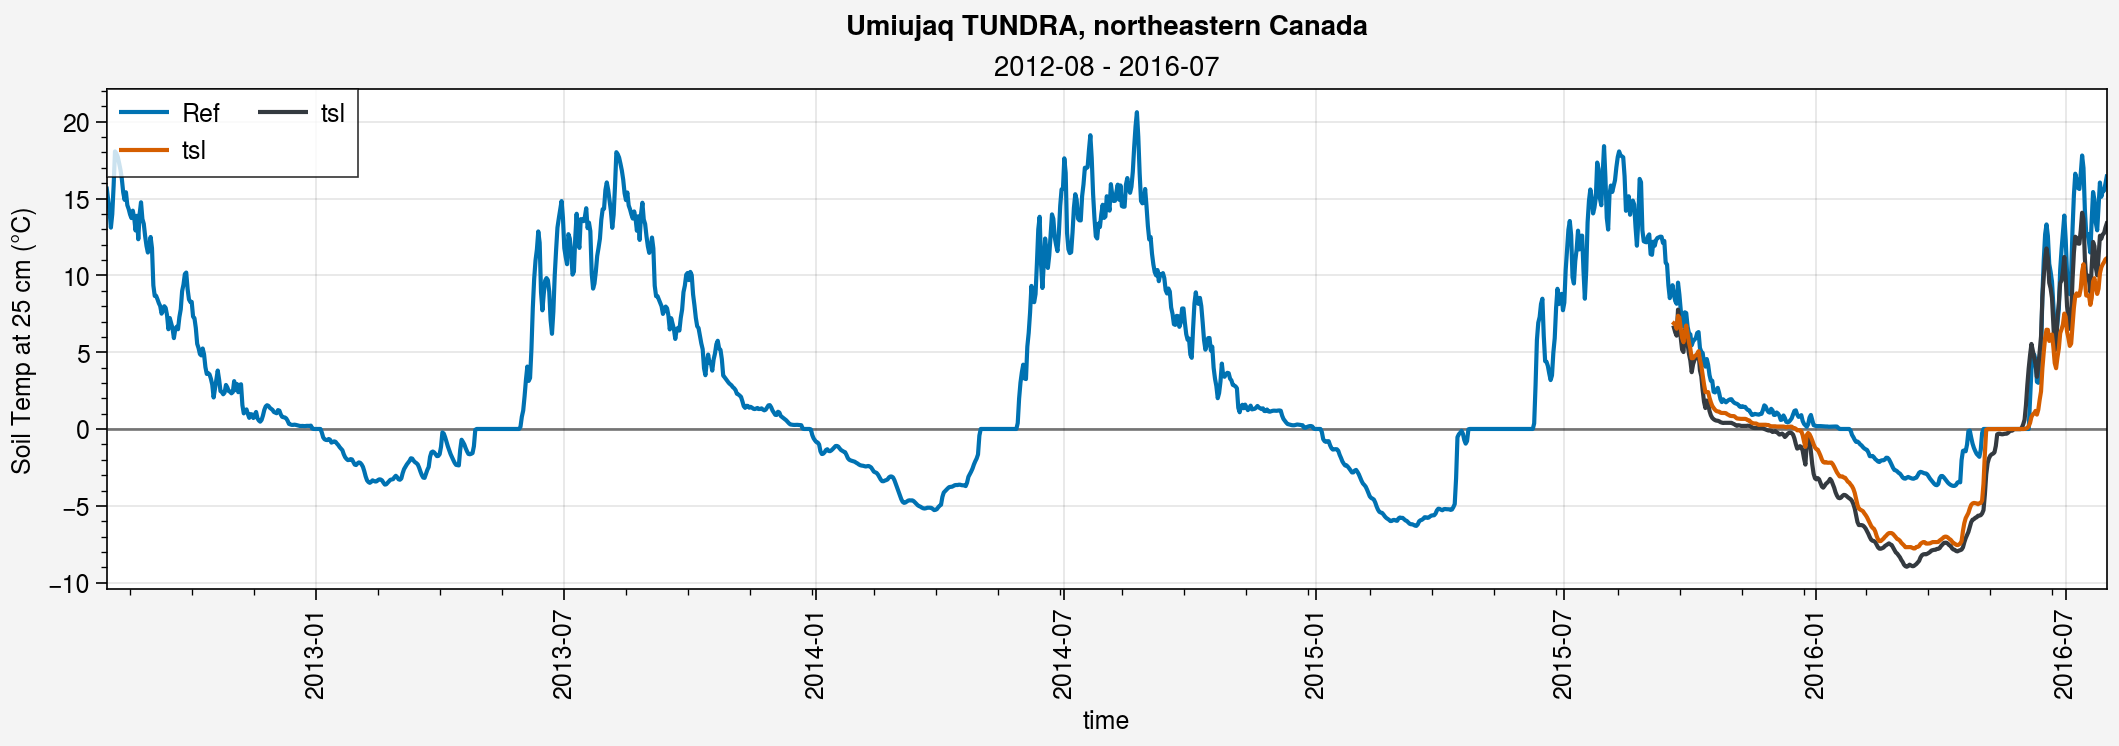

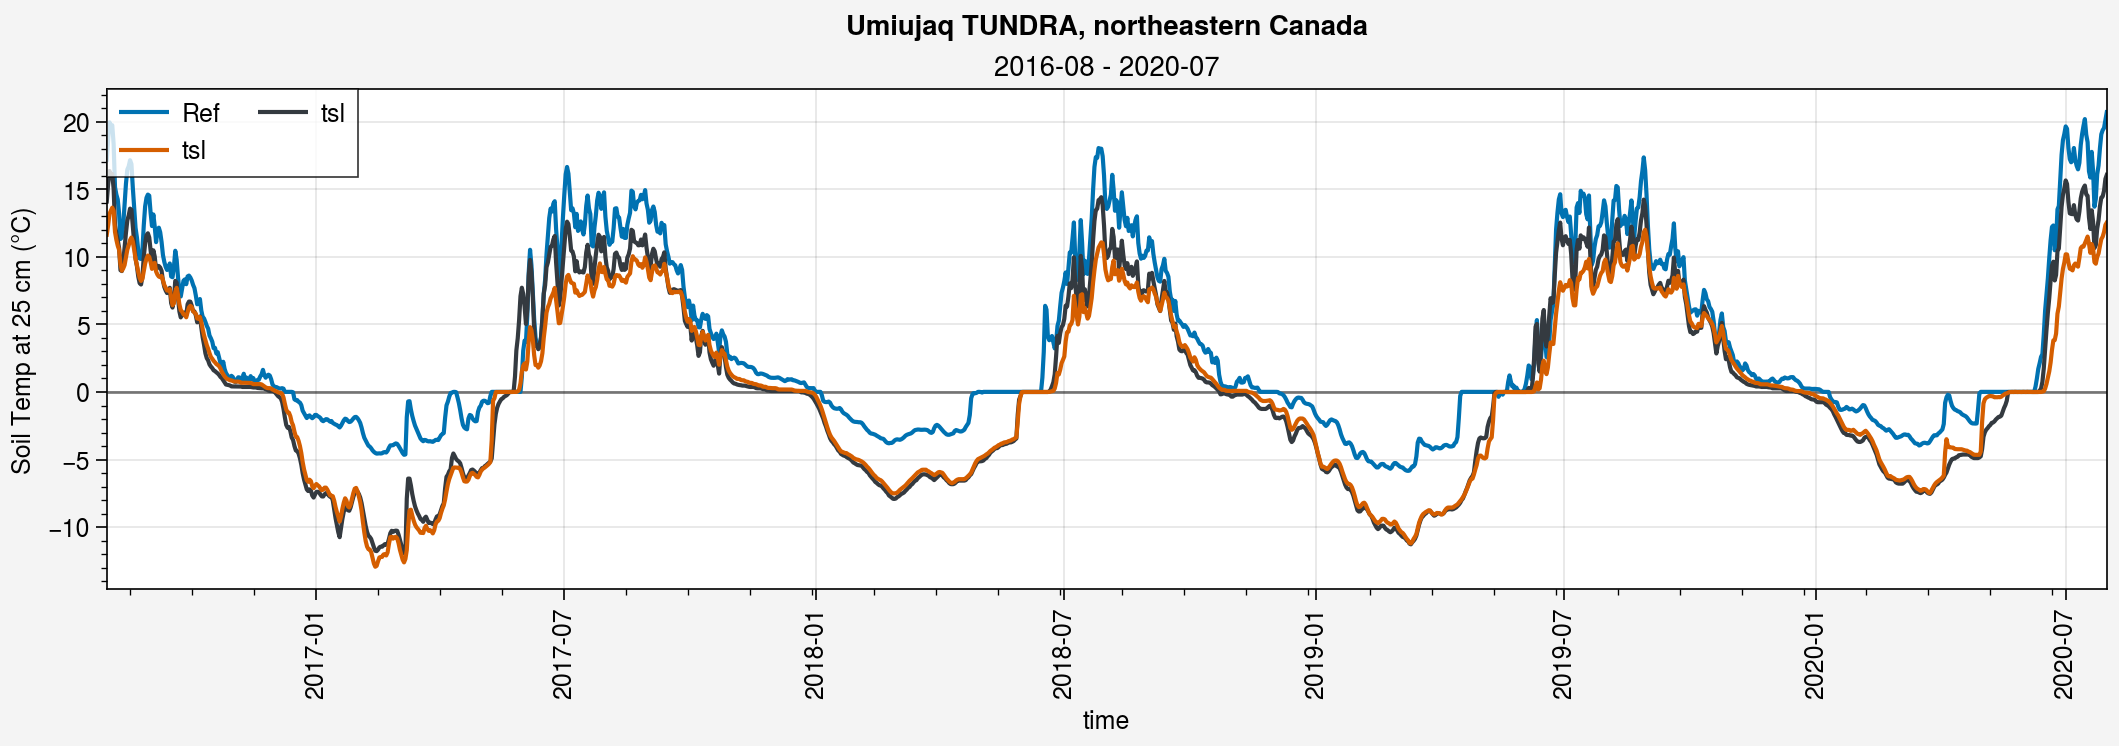

In [89]:
%matplotlib inline
gap = 4
color_obs = 'gray8'
sdepth = 0.25
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        # axs[0].plot(((ds_d.tsl.sel(time=period, layer=1)+ds_d.tsl.sel(time=period, layer=2))/2)-273.15, label=label)
        # axs[0].plot(((ds_d.tsl.sel(time=period).isel(layer=0)+ds_d.tsl.sel(time=period).isel(layer=1))/2)-273.15, label=label)
        # axs[0].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1)-273.15, label=label)
        axs[0].plot(ds_d.tsl.sel(time=period).sel(layer=sdepth, method='nearest')-273.15, label=label)
        
    # Obs
    # shadedata = np.concatenate((
    #     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)+1, axis=0),
    #     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)-1, axis=0),), axis=0)
    # axs[0].plot(ds_d_obs.tsl.sel(time=period, sdepth=sdepth), shadedata=shadedata, marker='.', color=color_obs)
    axs[0].plot(ds_d_obs.tsl.sel(time=period, sdepth=sdepth, veg='lichen'), color=color_obs)
    axs[0].plot(ds_d_obs.tsl.sel(time=period, sdepth=sdepth, veg='lowshrub'))
    
    axs[0].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Soil Temp at '+sdepth_label+' cm (°C)')
    
    fig.suptitle(site_longname)


### Volumetric water content

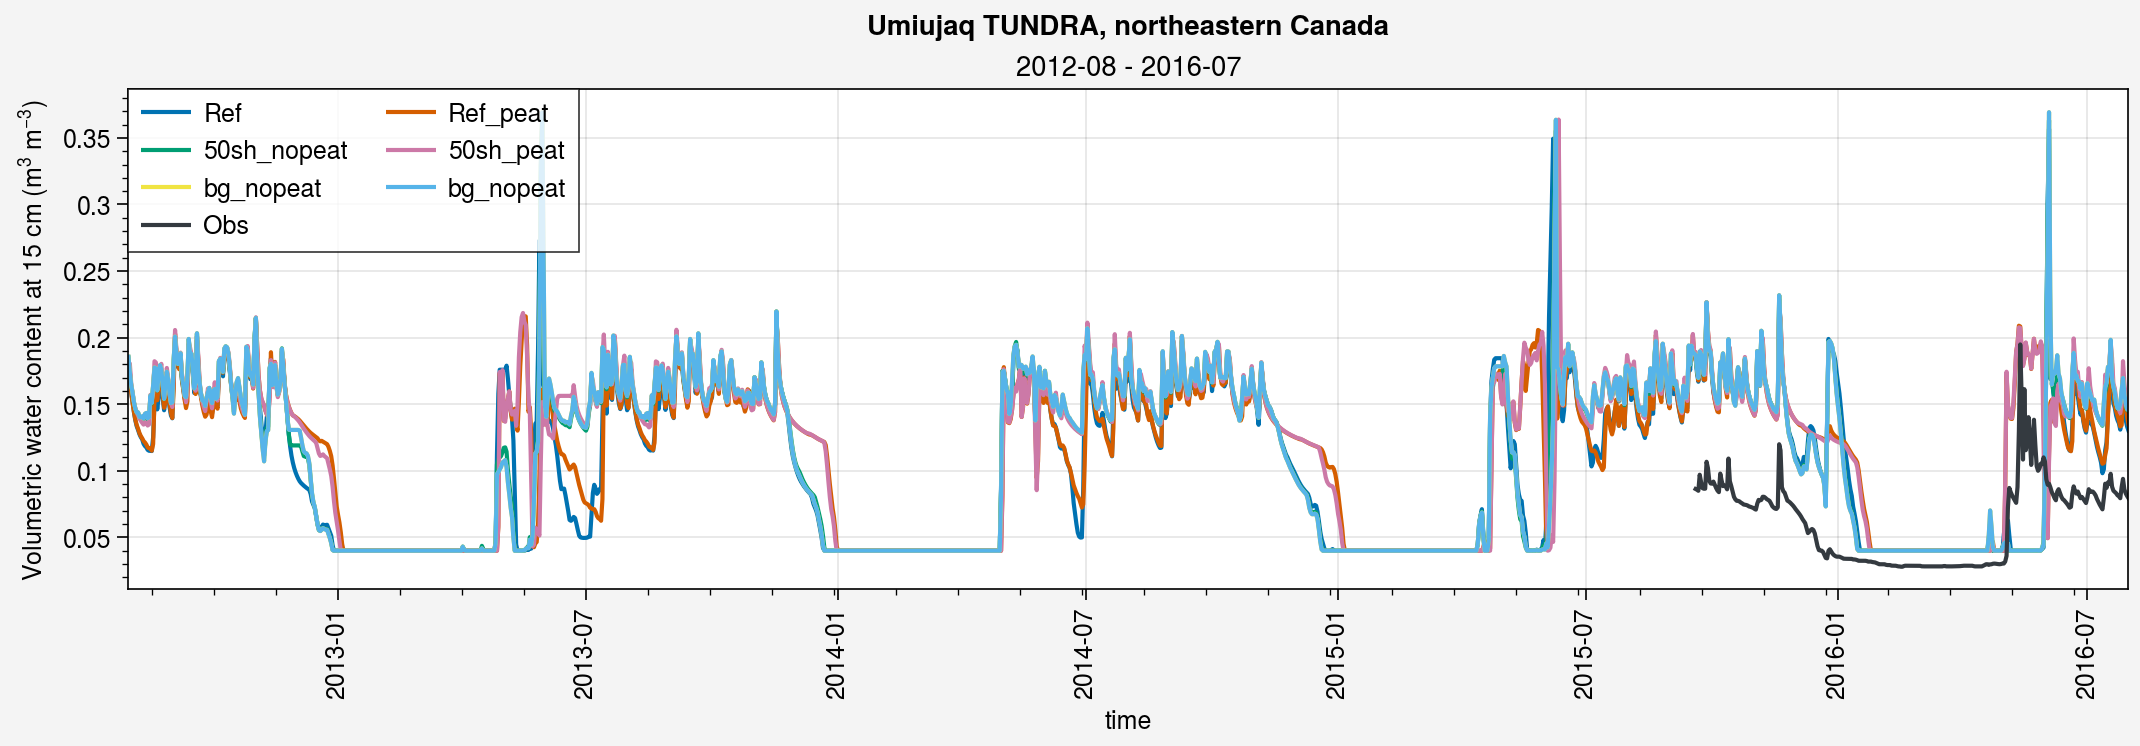

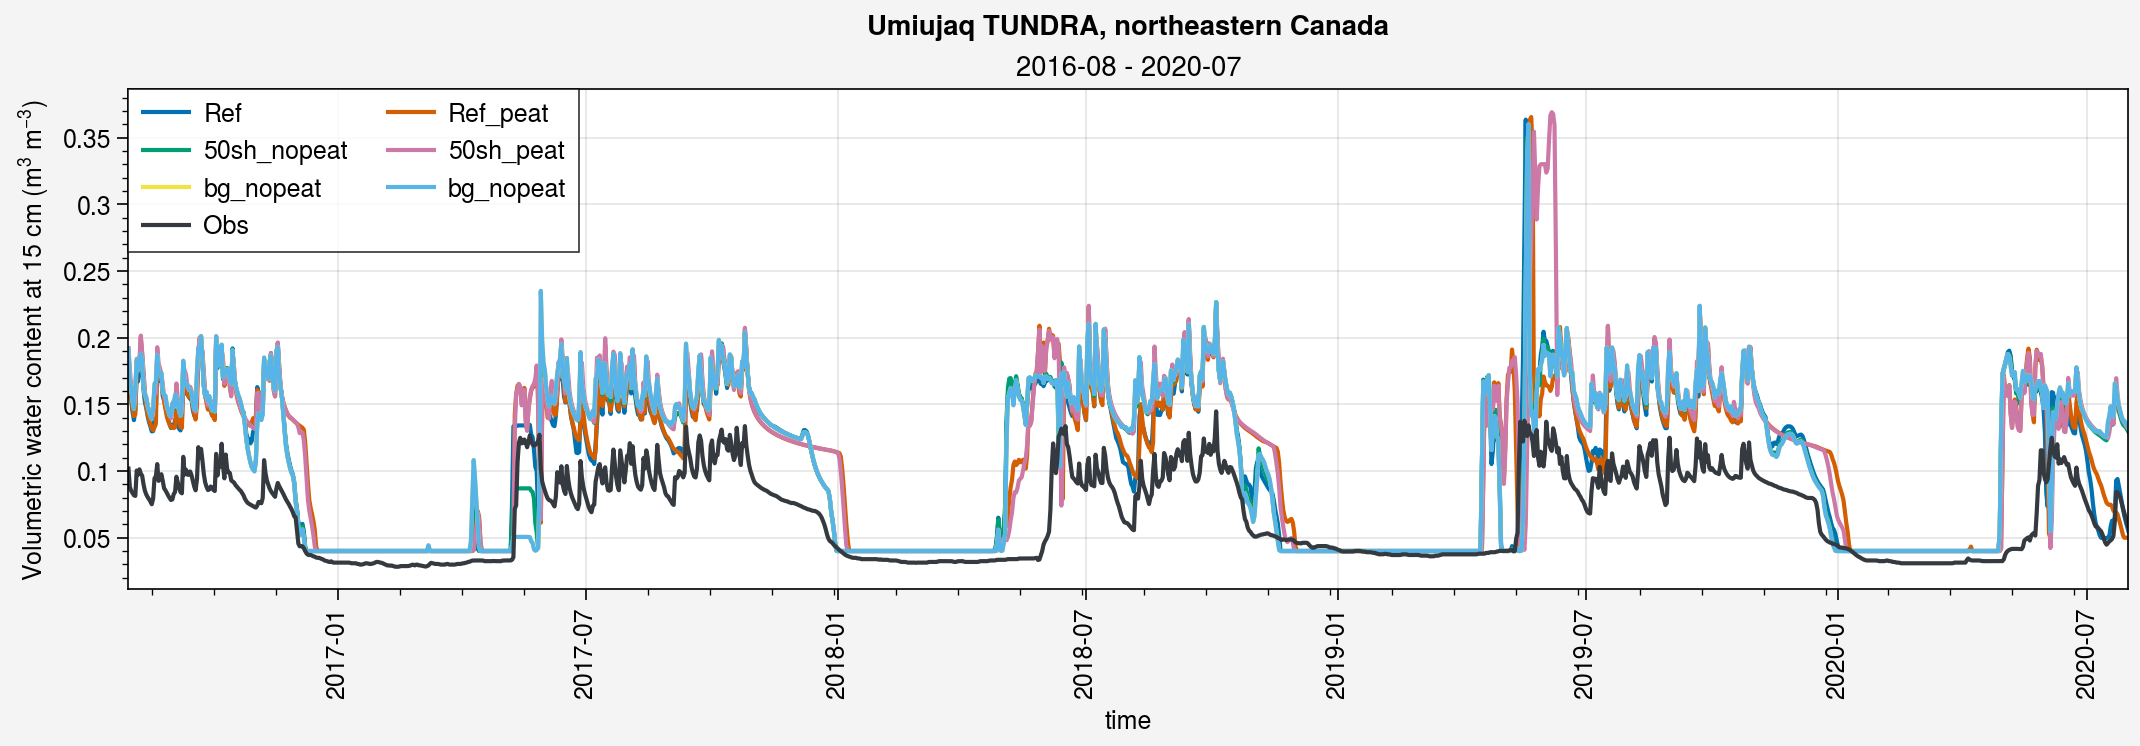

In [47]:
%matplotlib inline
gap = 4
color_obs = 'gray8'
sdepth = 0.15
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.mrsll.sel(time=period).sel(layer=sdepth, method='nearest')/100, label=label)
        
    # Obs
    axs[0].plot(ds_d_obs.mrsll.sel(time=period, sdepth=sdepth, veg='lowshrub'), color=color_obs, label='Obs')
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Volumetric water content at '+sdepth_label+' cm (m$^3$ m$^{-3}$)')
    
    fig.suptitle(site_longname)


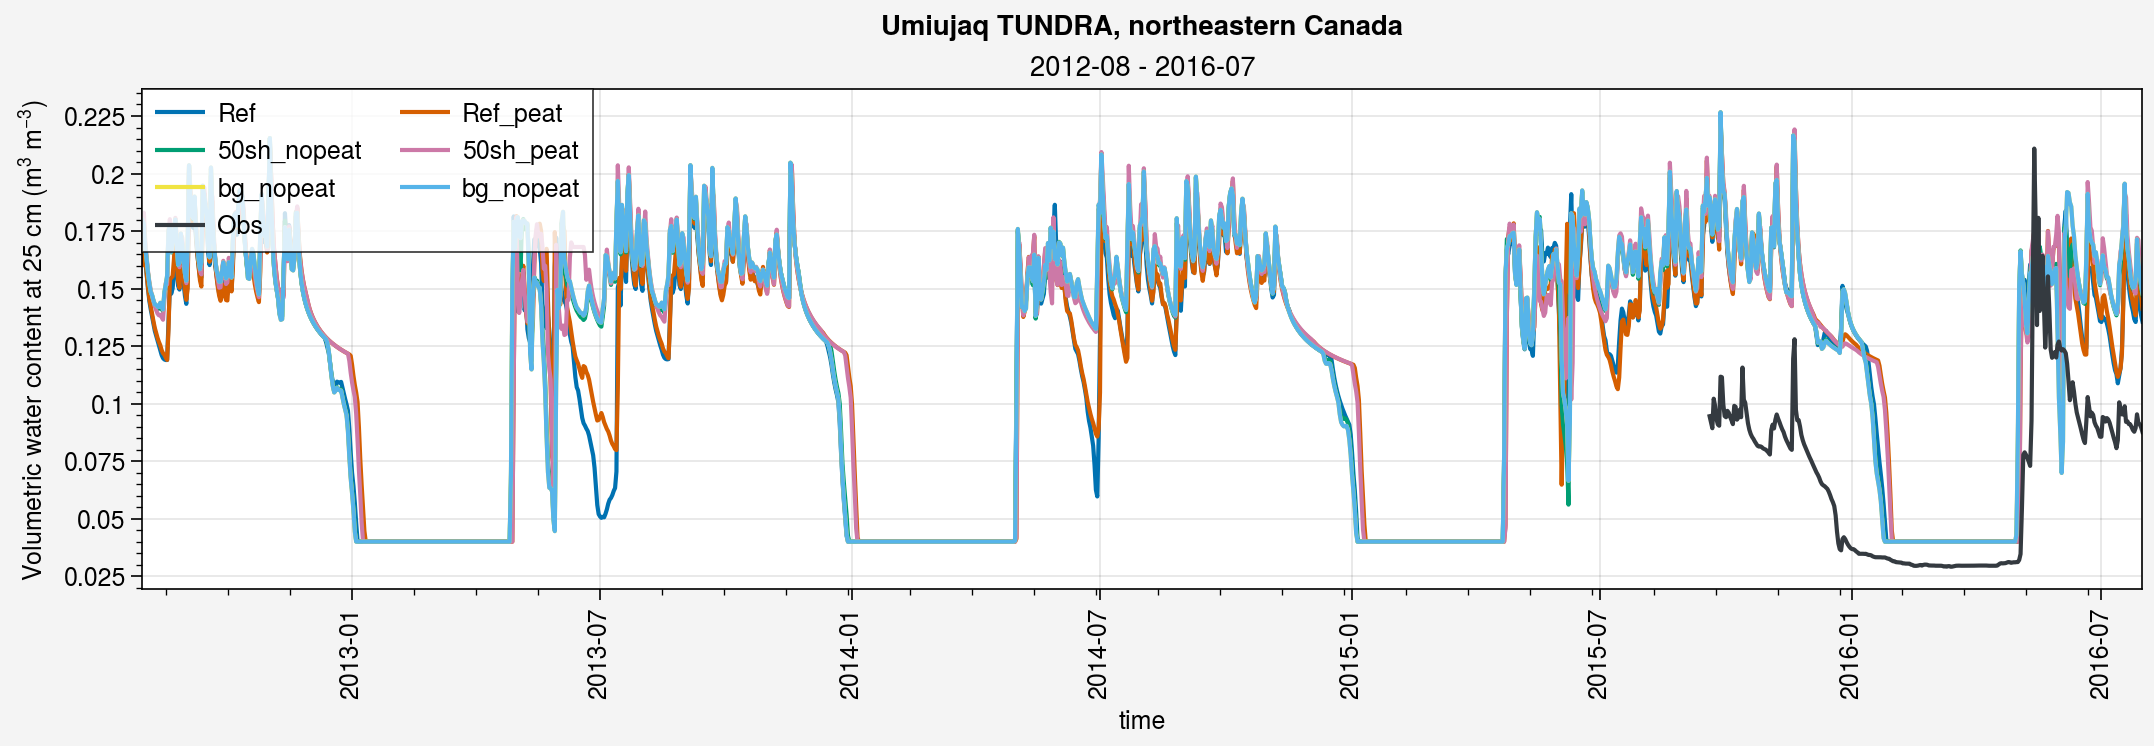

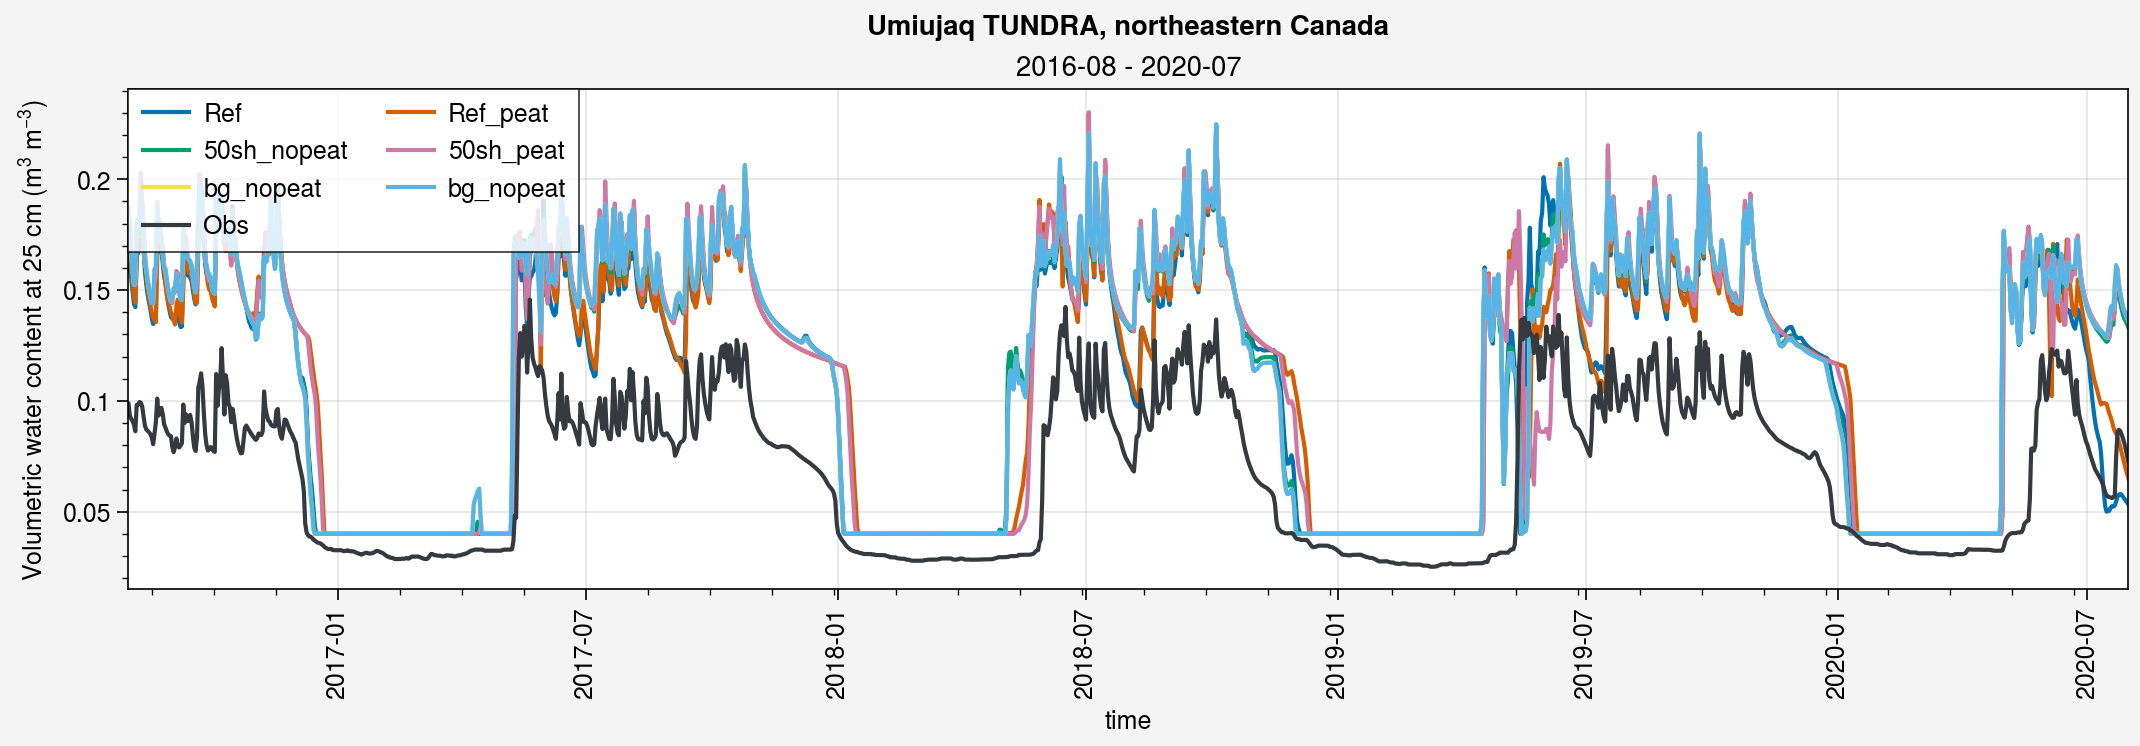

In [48]:
%matplotlib inline
gap = 4
color_obs = 'gray8'
sdepth = 0.25
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.mrsll.sel(time=period).sel(layer=sdepth, method='nearest')/100, label=label)
        
    # Obs
    axs[0].plot(ds_d_obs.mrsll.sel(time=period, sdepth=sdepth, veg='lowshrub'), color=color_obs, label='Obs')
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Volumetric water content at '+sdepth_label+' cm (m$^3$ m$^{-3}$)')
    
    fig.suptitle(site_longname)


## All

Text(0.5, 0.98, 'Umiujaq TUNDRA, northeastern Canada')

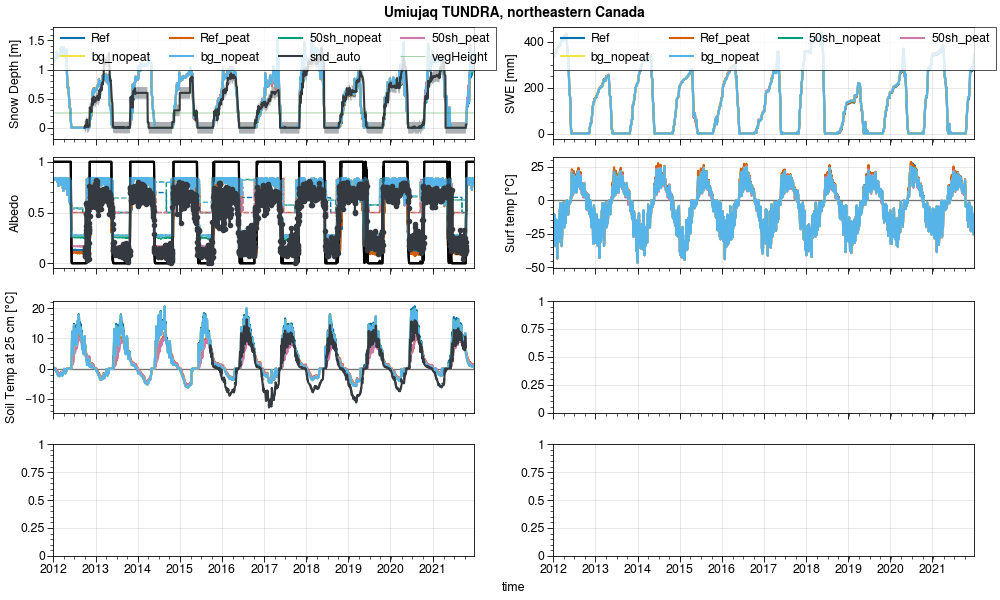

In [49]:
%matplotlib widget
fig, axs = pplt.subplots(nrows=4, ncols=2, figsize=(10,6), sharey=0)

lw = 0.5
period = slice(None, None)

##################
### Snow Depth ###
##################
ax = axs[0]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.sel(time=period).snd, label=label)

# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.sel(time=period).snd_auto.values+0.1, axis=0),
    np.expand_dims(ds_d_obs.sel(time=period).snd_auto.values-0.1, axis=0),), axis=0)
ax.plot(ds_d_obs.sel(time=period).snd_auto, shadedata=shadedata, color=color_obs)

# Veg
ax.plot(ds_d_list[0].sel(time=period).vegHeight, label='vegHeight', color='green', ls='-', lw=0.5, alpha=0.5)

ax.legend(loc='ul', ncols=4)
ax.format(ylabel='Snow Depth [m]')


##################
### SWE ###
##################
ax = axs[1]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.snw.sel(time=period), label=label)

# Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.snw_auto.sel(time=period).values+25, axis=0),
#     np.expand_dims(ds_d_obs.snw_auto.sel(time=period).values-25, axis=0),), axis=0)
# axs[0].plot(ds_d_obs.snw_auto.sel(time=period), shadedata=shadedata, color=color_obs)
# axs[0].plot(ds_d_obs.snw_man.sel(time=period), marker='.', color=color_obs)

ax.legend(loc='ul', ncols=4)
ax.format(ylabel='SWE [mm]')


##################
### Albedo ###
##################

# Simus
k = 0
ax = axs[2]
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.albs.sel(time=period), label=label+' (albs)', color='C'+str(k))
    ax.plot(ds_d.albsn.sel(time=period), label=label+' (albsn)', color='C'+str(k), ls='--', lw=1)
    ax.plot(ds_d.snc.sel(time=period), label=label+' (SCF)', color='k', alpha=0.5)
    
    k+=1

# Obs
ax.plot(ds_d_obs.albs.sel(time=period), marker='.', color=color_obs)

# ax.legend(loc='ul', ncols=2)
ax.format(ylabel='Albedo')


##################
### Surf temp ###
##################
ax = axs[3]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.ts.sel(time=period)-273.15, label=label)

# Obs
# ax.plot(ds_d_obs.ts.sel(time=period), color=color_obs)
ax.hlines(0, ds_d.ts.sel(time=period).time[0], ds_d.ts.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
ax.format(ylabel='Surf temp [°C]')


##################
### Soil temp ###
##################
ax = axs[4]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    # axs[0].plot(((ds_d.tsl.sel(time=period, layer=1)+ds_d.tsl.sel(time=period, layer=2))/2)-273.15, label=label)
    # axs[0].plot(((ds_d.tsl.sel(time=period).isel(layer=0)+ds_d.tsl.sel(time=period).isel(layer=1))/2)-273.15, label=label)
    # axs[0].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1)-273.15, label=label)
    ax.plot(ds_d.tsl.sel(time=period).sel(layer=sdepth, method='nearest')-273.15, label=label)
    
# Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)+1, axis=0),
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)-1, axis=0),), axis=0)
# axs[0].plot(ds_d_obs.tsl.sel(time=period, sdepth=sdepth), shadedata=shadedata, marker='.', color=color_obs)
ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=sdepth, veg='lichen'), color=color_obs)
ax.plot(ds_d_obs.tsl.sel(time=period, sdepth=sdepth, veg='lowshrub'), color=color_obs, ls='--')

ax.hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
# ax.legend(loc='ul', ncols=2)
ax.format(ylabel='Soil Temp at '+sdepth_label+' cm [°C]')

fig.suptitle(site_longname)